## 0. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf

%matplotlib inline

2023-02-06 12:47:07.107871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Load and Analyze the Images

In [3]:
from tensorflow.keras.datasets import cifar10

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train.shape

(50000, 32, 32, 3)

Further split the test data (evenly) in order to get a validation set. This will be useful if we choose to do hyperparamter tuning.

In [6]:
from sklearn.model_selection import train_test_split

x_val,x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=101)

We can plot some of the images to see what they generally look like.

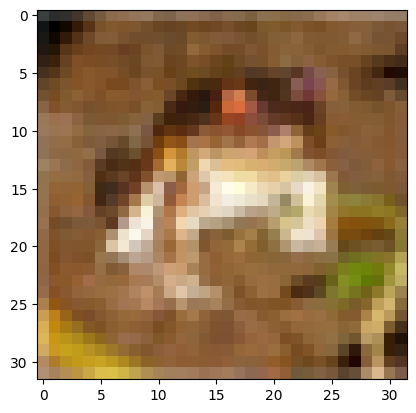

In [7]:
plt.imshow(x_train[0]) 

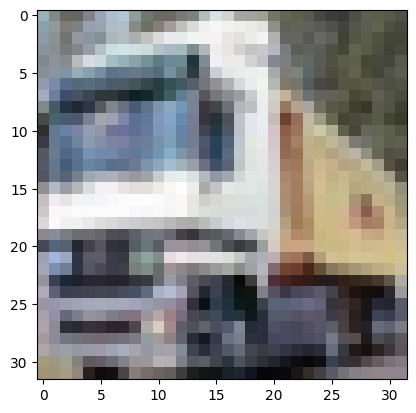

In [8]:
plt.imshow(x_train[1]) 

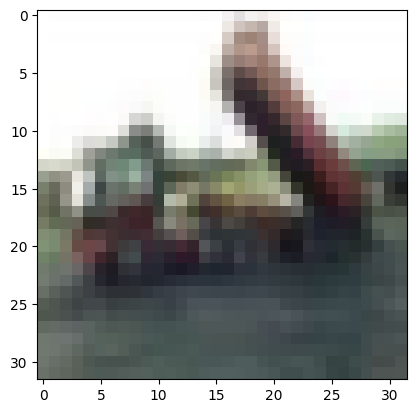

In [9]:
plt.imshow(x_train[2]) 

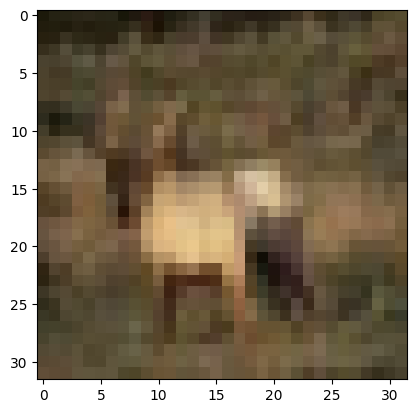

In [10]:
plt.imshow(x_train[3]) 

These are only 32x32 images and are not detailed that well.

## 2. Preprocessing

Normalizing all the data to be in [0,1] instead of [0,255].

In [11]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

We need to onehot-encode the labels in order to allow for our CNN to have a 10-node dense layer at the end.

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
cat_transformer = OneHotEncoder(sparse_output=False)

In [14]:
y_train_cat = cat_transformer.fit_transform(y_train.reshape(-1,1))
y_val_cat = cat_transformer.transform(y_val.reshape(-1,1))
y_test_cat = cat_transformer.transform(y_test.reshape(-1,1))

In [15]:
y_train_cat[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [16]:
y_train[0]

array([6], dtype=uint8)

We don't have to do reshaping because our data actually has the fourth dimension (multiple color channels).

## 3. Modelling

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [18]:
model = Sequential()

model.add(
    Conv2D(
        input_shape=x_train.shape[1:] , # input_shape is fixed by actual data
        filters=2**5, kernel_size=(4,4), strides=(1,1), padding='same', activation='relu' # hyperparameters 
    )
)
model.add(
    MaxPool2D(
        pool_size=(2,2) # hyperparameters 
    )
)

model.add(
    Conv2D(
        filters=2**6, kernel_size=(4,4), strides=(1,1), padding='same', activation='relu' # hyperparameters 
    )
)
model.add(
    MaxPool2D(
        pool_size=(2,2) # hyperparameters 
    )
)

model.add(
    Conv2D(
        filters=2**7, kernel_size=(4,4), strides=(1,1), padding='same', activation='relu' # hyperparameters 
    )
)
model.add(
    MaxPool2D(
        pool_size=(2,2) # hyperparameters 
    )
)

model.add(Flatten()) # must be here 

model.add(
    Dense(
        units=2**9, activation='relu' # hyperparameters 
    )
)

# OUTPUT LAYER
# Use softmax activation for multiclass classification
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2023-02-06 12:47:24.675375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

print(datetime.now().strftime("%Y-%m-%d--%H%M"))
log_directory = f'cnn_cifar10/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
print(log_directory)

2023-02-06--1247
cnn_cifar10/fit/20230206-124724


In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [22]:
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-06 12:47:24.917370: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-06 12:47:24.917386: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-06 12:47:24.919676: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [23]:
model.fit(x_train, y_train_cat, epochs=20, batch_size=64, validation_data=(x_val, y_val_cat), callbacks=[early_stop, board])

Epoch 1/20
  3/782 [..............................] - ETA: 1:07 - loss: 2.3298 - accuracy: 0.1094

2023-02-06 12:47:27.721129: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-06 12:47:27.721160: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-06 12:47:27.800870: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-06 12:47:27.807651: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-06 12:47:27.813486: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_cifar10/fit/20230206-124724/plugins/profile/2023_02_06_12_47_27/HOBNJML-C40PLVD.xplane.pb


782/782 [==============================] - 61s 76ms/step - loss: 1.4324 - accuracy: 0.4790 - val_loss: 1.1033 - val_accuracy: 0.6052
Epoch 2/20
782/782 [==============================] - 58s 74ms/step - loss: 0.9712 - accuracy: 0.6586 - val_loss: 0.9536 - val_accuracy: 0.6702
Epoch 3/20
782/782 [==============================] - 57s 73ms/step - loss: 0.7734 - accuracy: 0.7287 - val_loss: 0.8404 - val_accuracy: 0.7086
Epoch 4/20
782/782 [==============================] - 57s 73ms/step - loss: 0.6365 - accuracy: 0.7768 - val_loss: 0.7690 - val_accuracy: 0.7430
Epoch 5/20
782/782 [==============================] - 60s 77ms/step - loss: 0.5166 - accuracy: 0.8176 - val_loss: 0.7673 - val_accuracy: 0.7406
Epoch 6/20
782/782 [==============================] - 65s 83ms/step - loss: 0.4080 - accuracy: 0.8550 - val_loss: 0.7745 - val_accuracy: 0.7554
Epoch 7/20
782/782 [==============================] - 62s 80ms/step - loss: 0.3145 - accuracy: 0.8895 - val_loss: 0.9243 - val_accuracy: 0.7414
Epo

## 4. Evaluation

In [24]:
metrics = pd.DataFrame(model.history.history)

<AxesSubplot: >

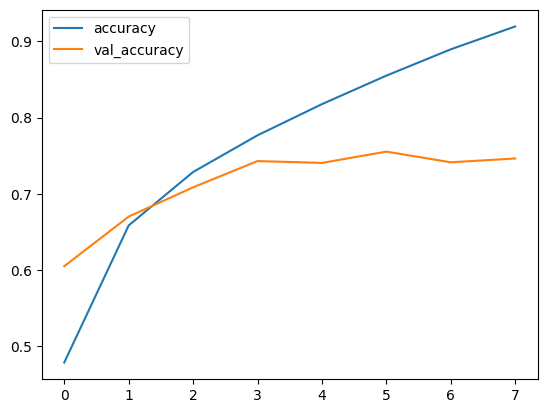

In [25]:
metrics[['accuracy', 'val_accuracy']].plot()

In [26]:
model.evaluate(x_test, y_test_cat)

157/157 [==============================] - 1s 8ms/step - loss: 1.0421 - accuracy: 0.7352


[1.0420969724655151, 0.7351999878883362]

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
y_pred = np.argmax(model.predict(x_test), axis=1)

157/157 [==============================] - 1s 8ms/step


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75       500
           1       0.87      0.88      0.87       500
           2       0.73      0.53      0.62       500
           3       0.58      0.49      0.53       500
           4       0.61      0.79      0.68       500
           5       0.62      0.67      0.64       500
           6       0.83      0.80      0.81       500
           7       0.79      0.77      0.78       500
           8       0.85      0.83      0.84       500
           9       0.84      0.76      0.80       500

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.73      5000
weighted avg       0.74      0.74      0.73      5000



In [30]:
cm = confusion_matrix(y_test, y_pred)

In [31]:
label_dict = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

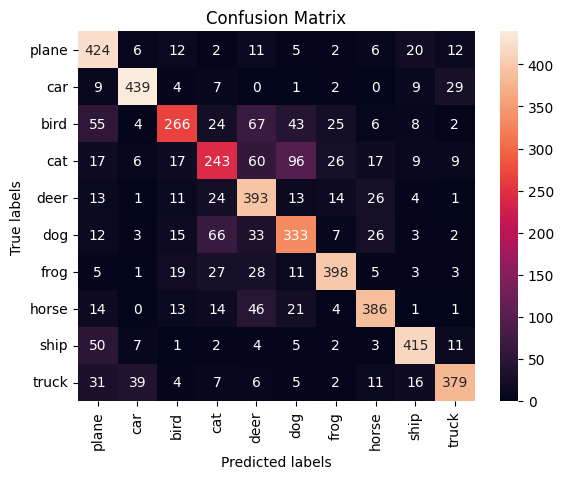

In [32]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_xticklabels(label_dict.values(), rotation='vertical')
ax.set_yticklabels(label_dict.values(), rotation='horizontal')
ax.set_title('Confusion Matrix'); 

## 5. Explore Intermediate Outputs of the Model

First, lets get a sample image for each class and display them.

In [35]:
samples = {key: None for key in list(set(y_train[:,0]))}
done = False
idx = 0

while not done:
    if samples[y_train[idx,0]] == None:
        print(f'Found {label_dict[y_train[idx,0]]} at index {idx}.')
        samples[y_train[idx, 0]] = idx
        test_done = True
        for k in samples.keys():
            if samples[k] == None:
                test_done = False
                break
        if test_done:
            done = True
    idx += 1

print(samples)

Found frog at index 0.
Found truck at index 1.
Found deer at index 3.
Found car at index 4.
Found bird at index 6.
Found horse at index 7.
Found ship at index 8.
Found cat at index 9.
Found dog at index 27.
Found plane at index 29.
{0: 29, 1: 4, 2: 6, 3: 9, 4: 3, 5: 27, 6: 0, 7: 7, 8: 8, 9: 1}


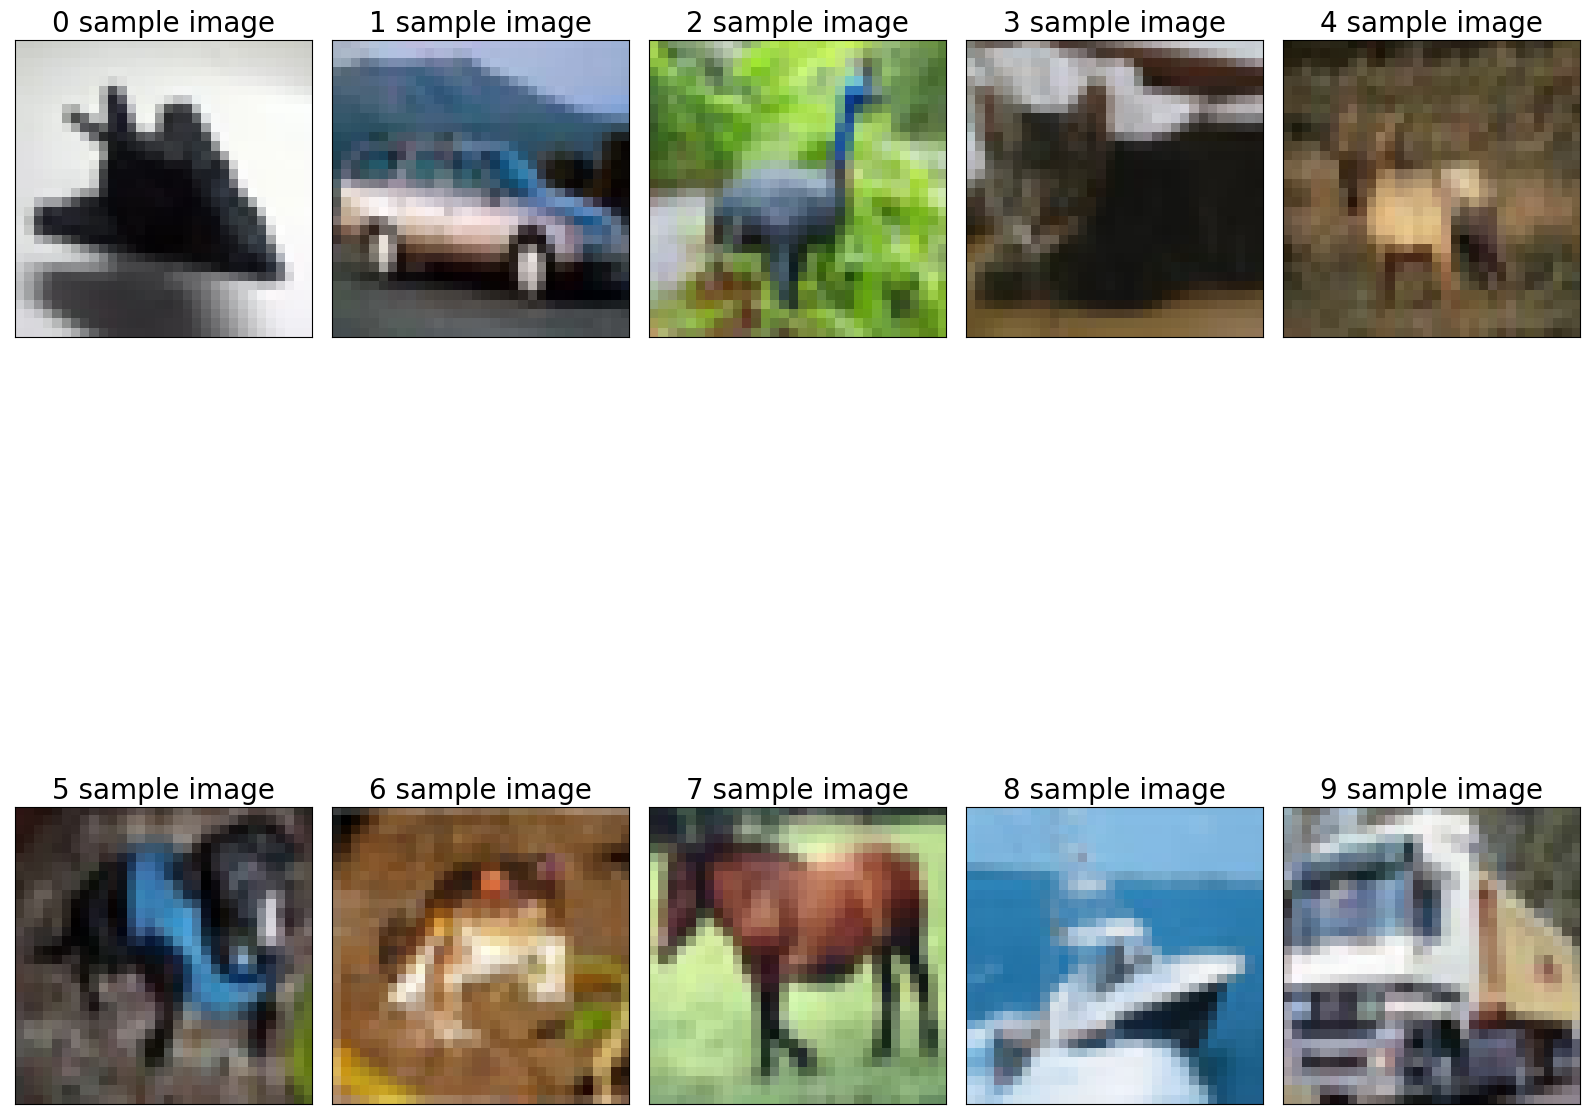

In [36]:
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=(len(samples.keys()) + (ncols-1))//ncols, ncols=ncols)
for i in samples.keys():
    axs[i//ncols, i%ncols].set_xticks([])
    axs[i//ncols, i%ncols].set_yticks([])
    axs[i//ncols, i%ncols].set_title(f'{i} sample image', fontsize=20)
    axs[i//ncols, i%ncols].imshow(x_train[samples[i]])
# show the figure
plt.tight_layout()
plt.show()

We can create a derived model that is just the output of the first layer

In [37]:
from tensorflow.keras.models import Model

fmap_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
fmap_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
Total params: 1,568
Trainable params: 1,568
Non-trainable params: 0
_________________________________________________________________


This is a convolving function that applies the kernel (filter) to the image.

In [38]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        #print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [71]:
# Get the Conv2D layer and its weights from the derived model

layer = fmap_model.layers[1]
print(layer.name)
kernels, biases = layer.get_weights()
kernels_trans = [(kernels[:,:,:,i] - np.min(kernels[:,:,:,i]))/(np.max(kernels[:,:,:,i]) - np.min(kernels[:,:,:,i])) for i in range(kernels.shape[3])]
kernels_trans = np.array(kernels_trans)
print(kernels_trans.shape)

conv2d
(32, 4, 4, 3)


Below we show to the outputs of the derived model (filtered images after first transformation) and display the images in black and white.

1/1 [==============================] - 0s 59ms/step
(1, 32, 32)


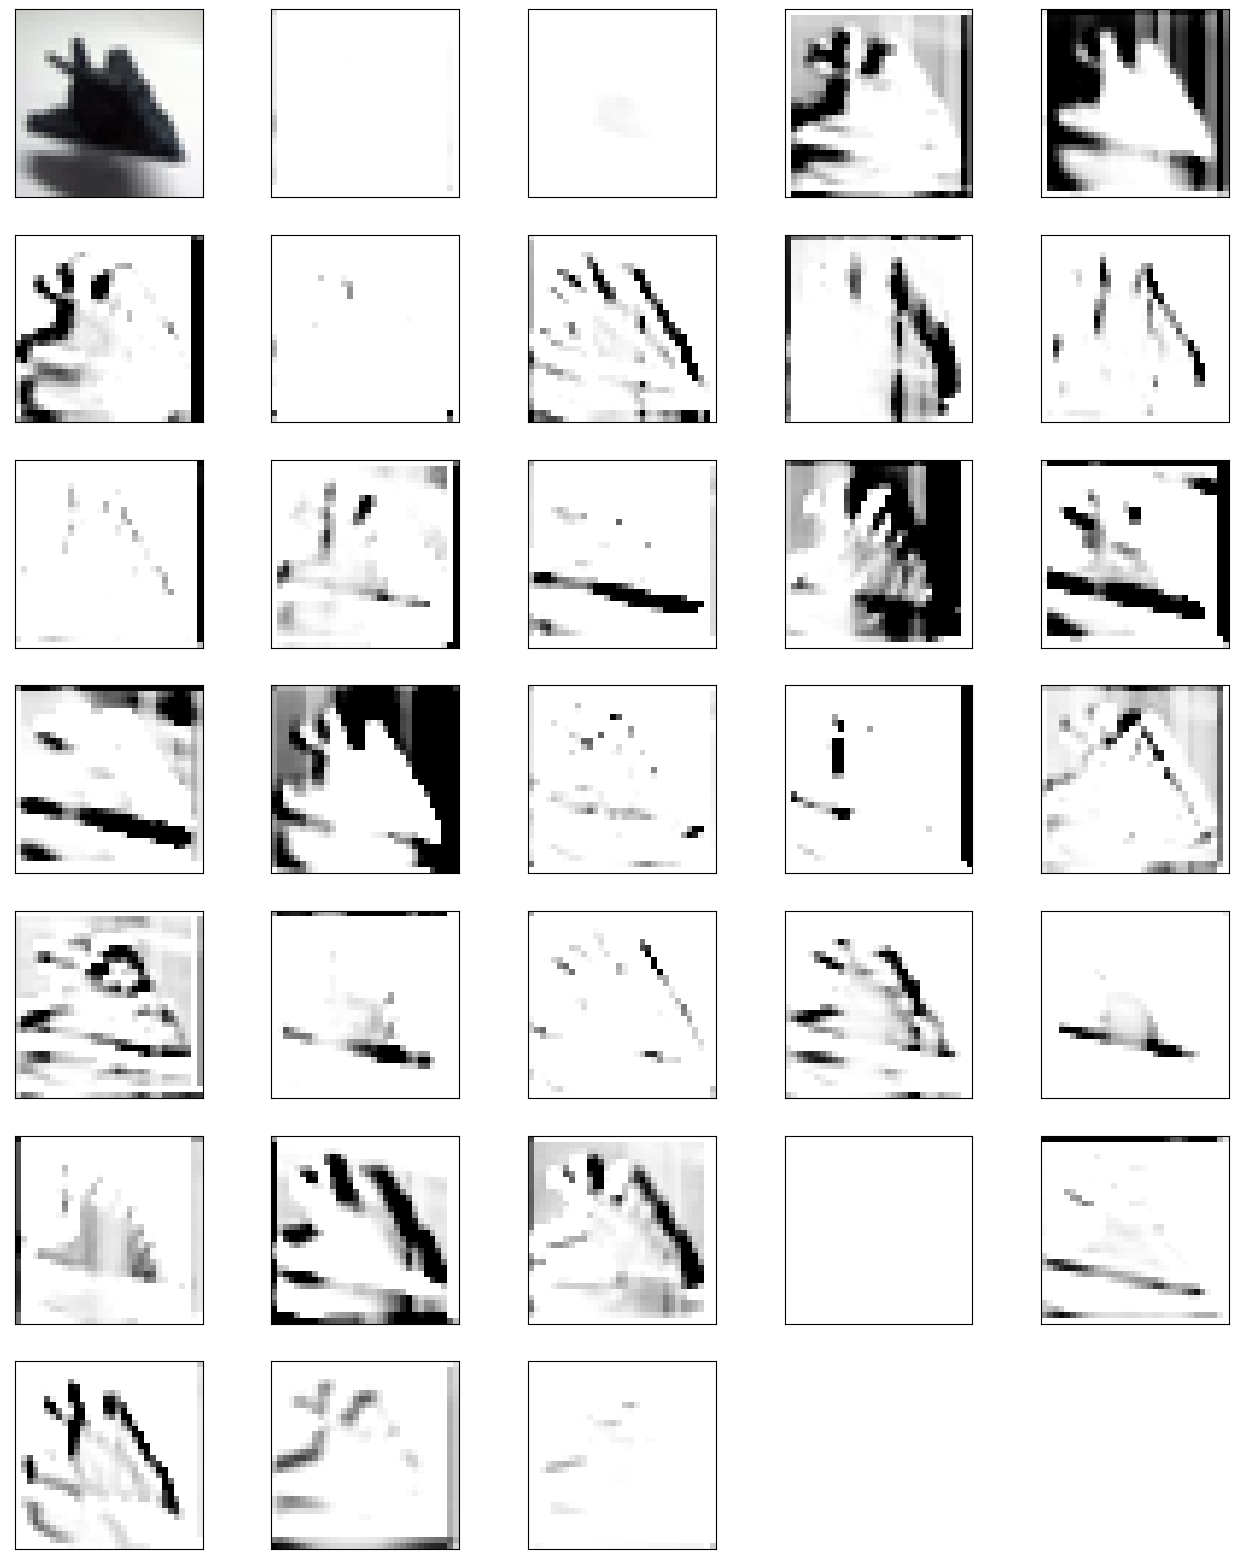

In [42]:
val = 0
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))

print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

We can also print colored images. Here we take the original image and apply the filter to each RGB channel, and then display the filtered image.

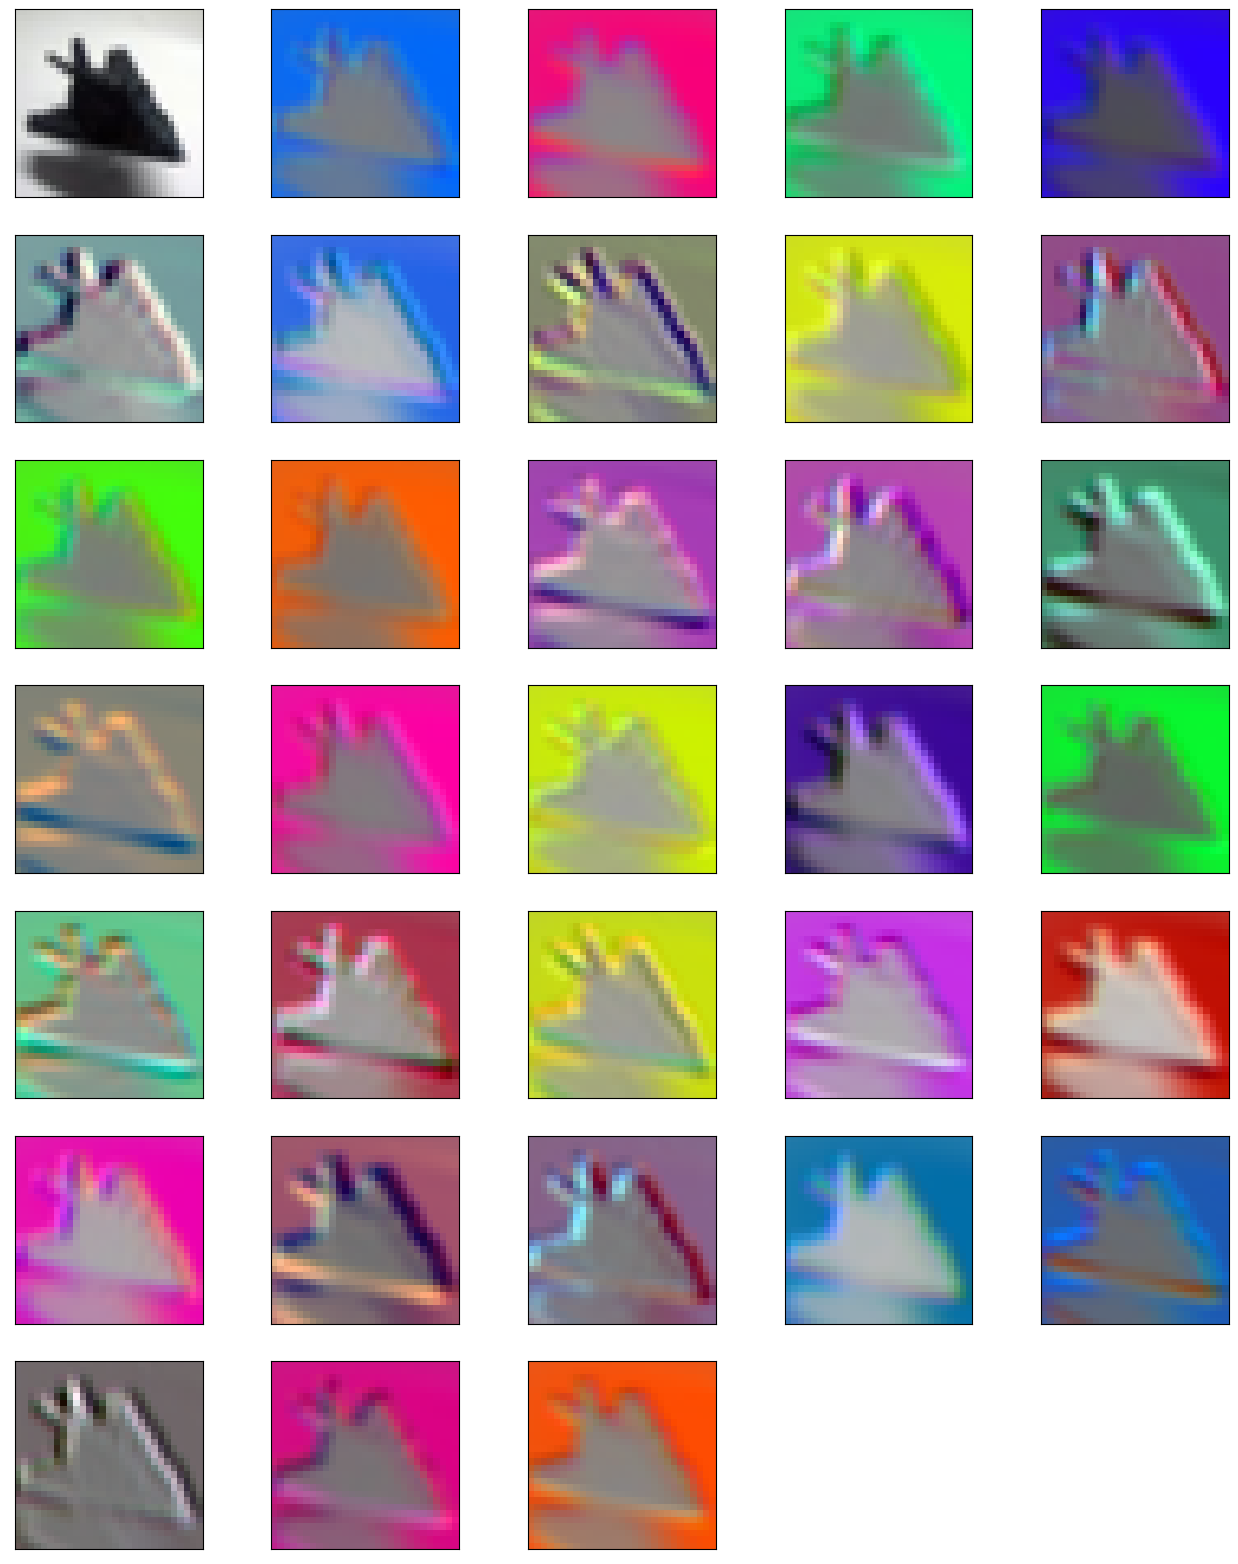

In [43]:
val = 0
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 29ms/step
(1, 32, 32)


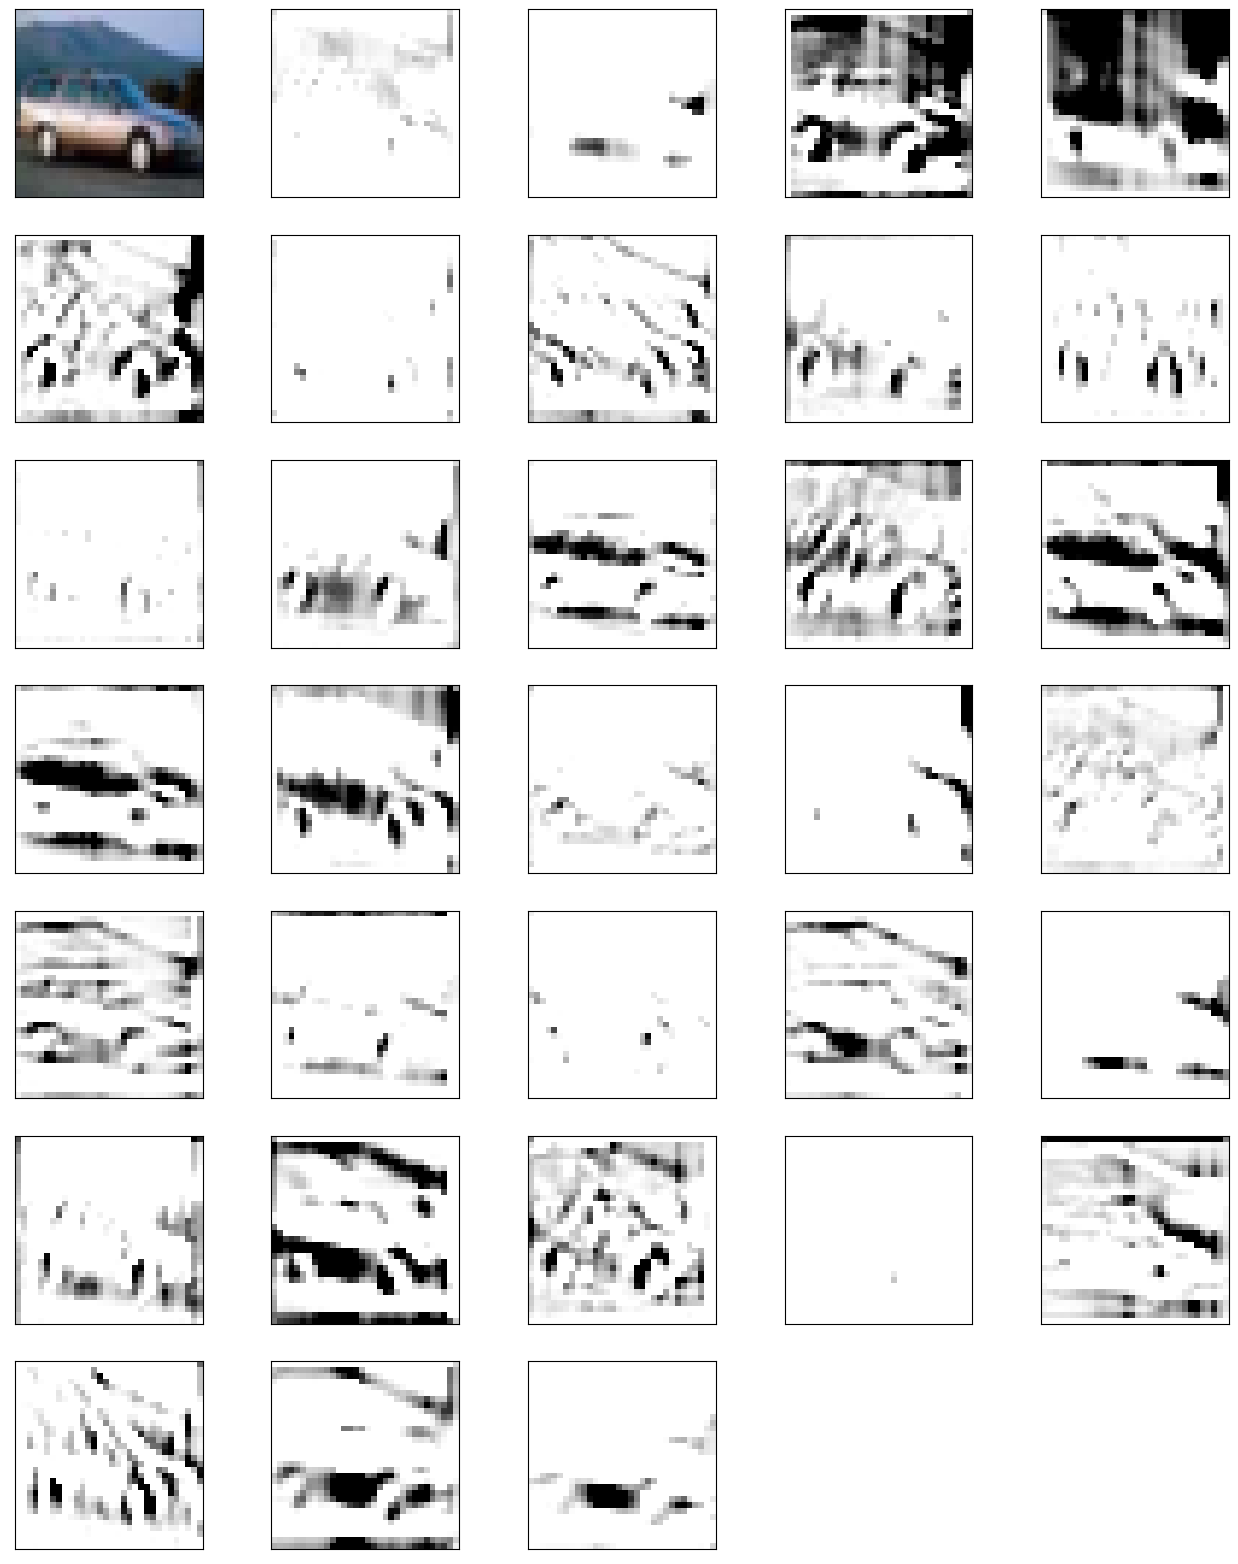

In [44]:
val = 1
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))

print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

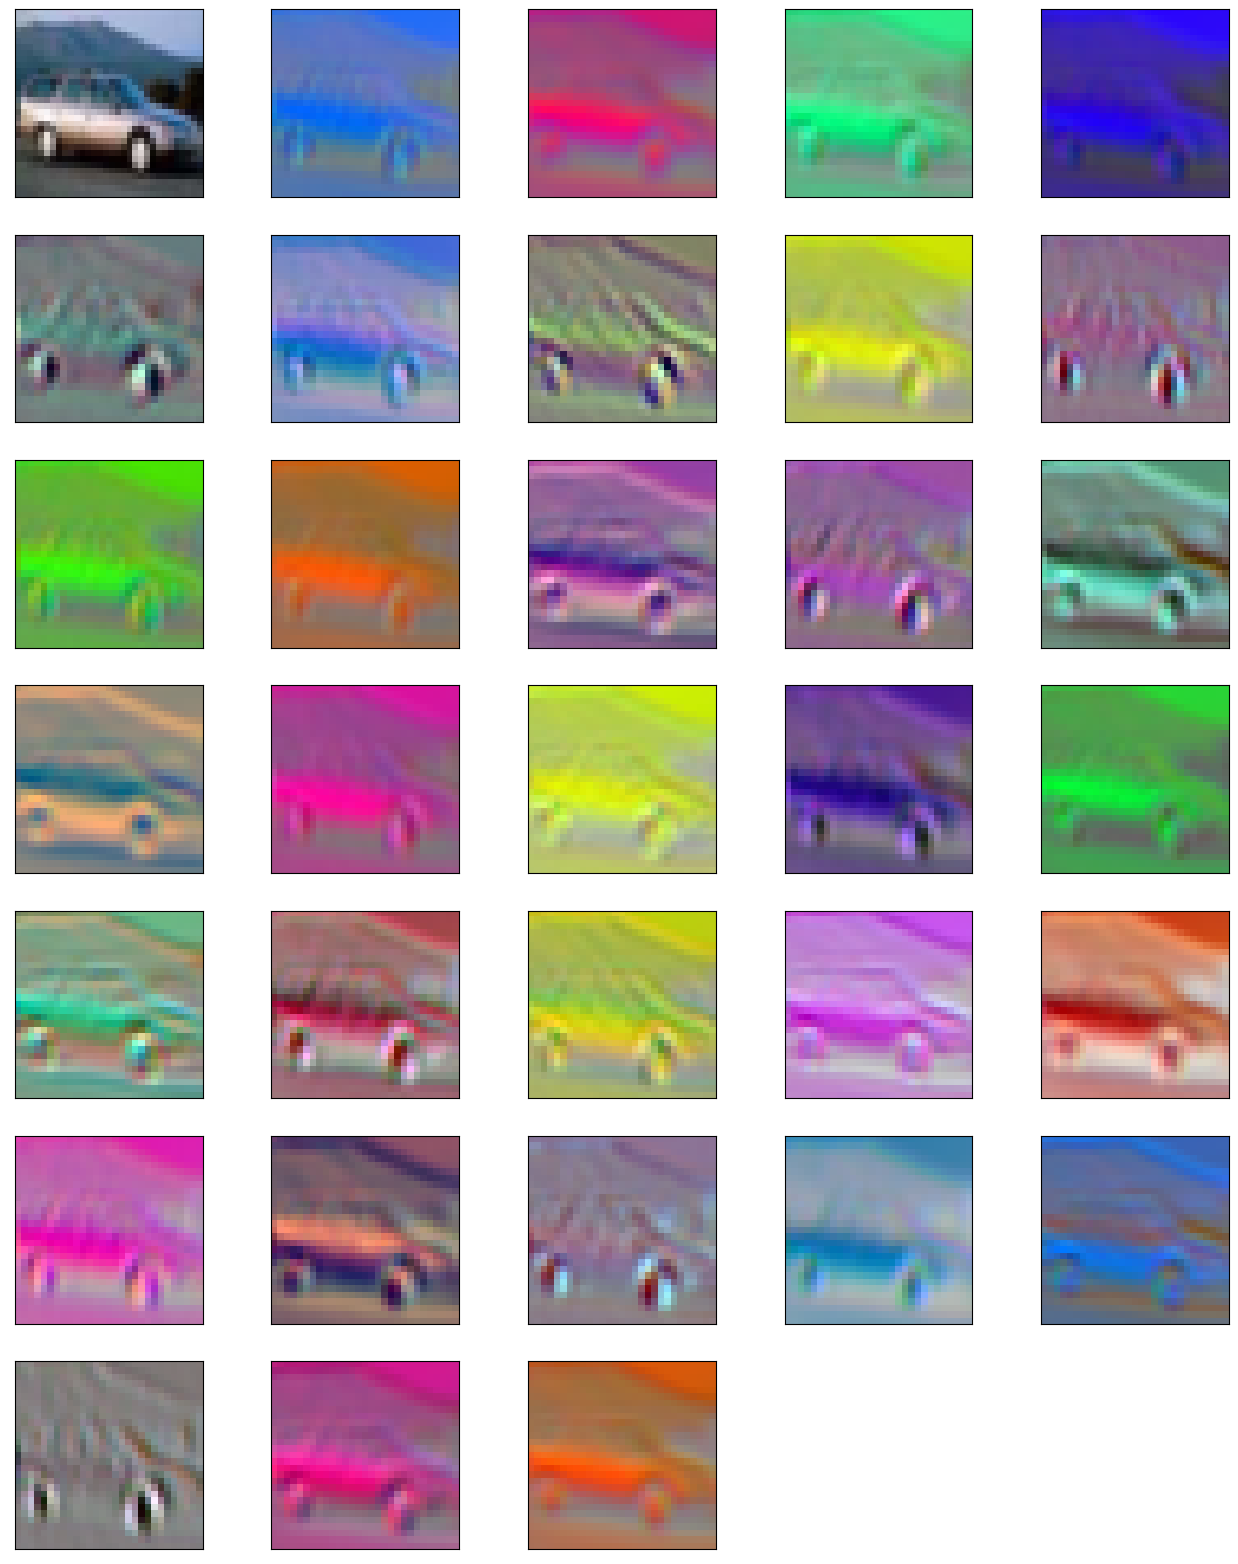

In [45]:
val = 1
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 19ms/step
(1, 32, 32)


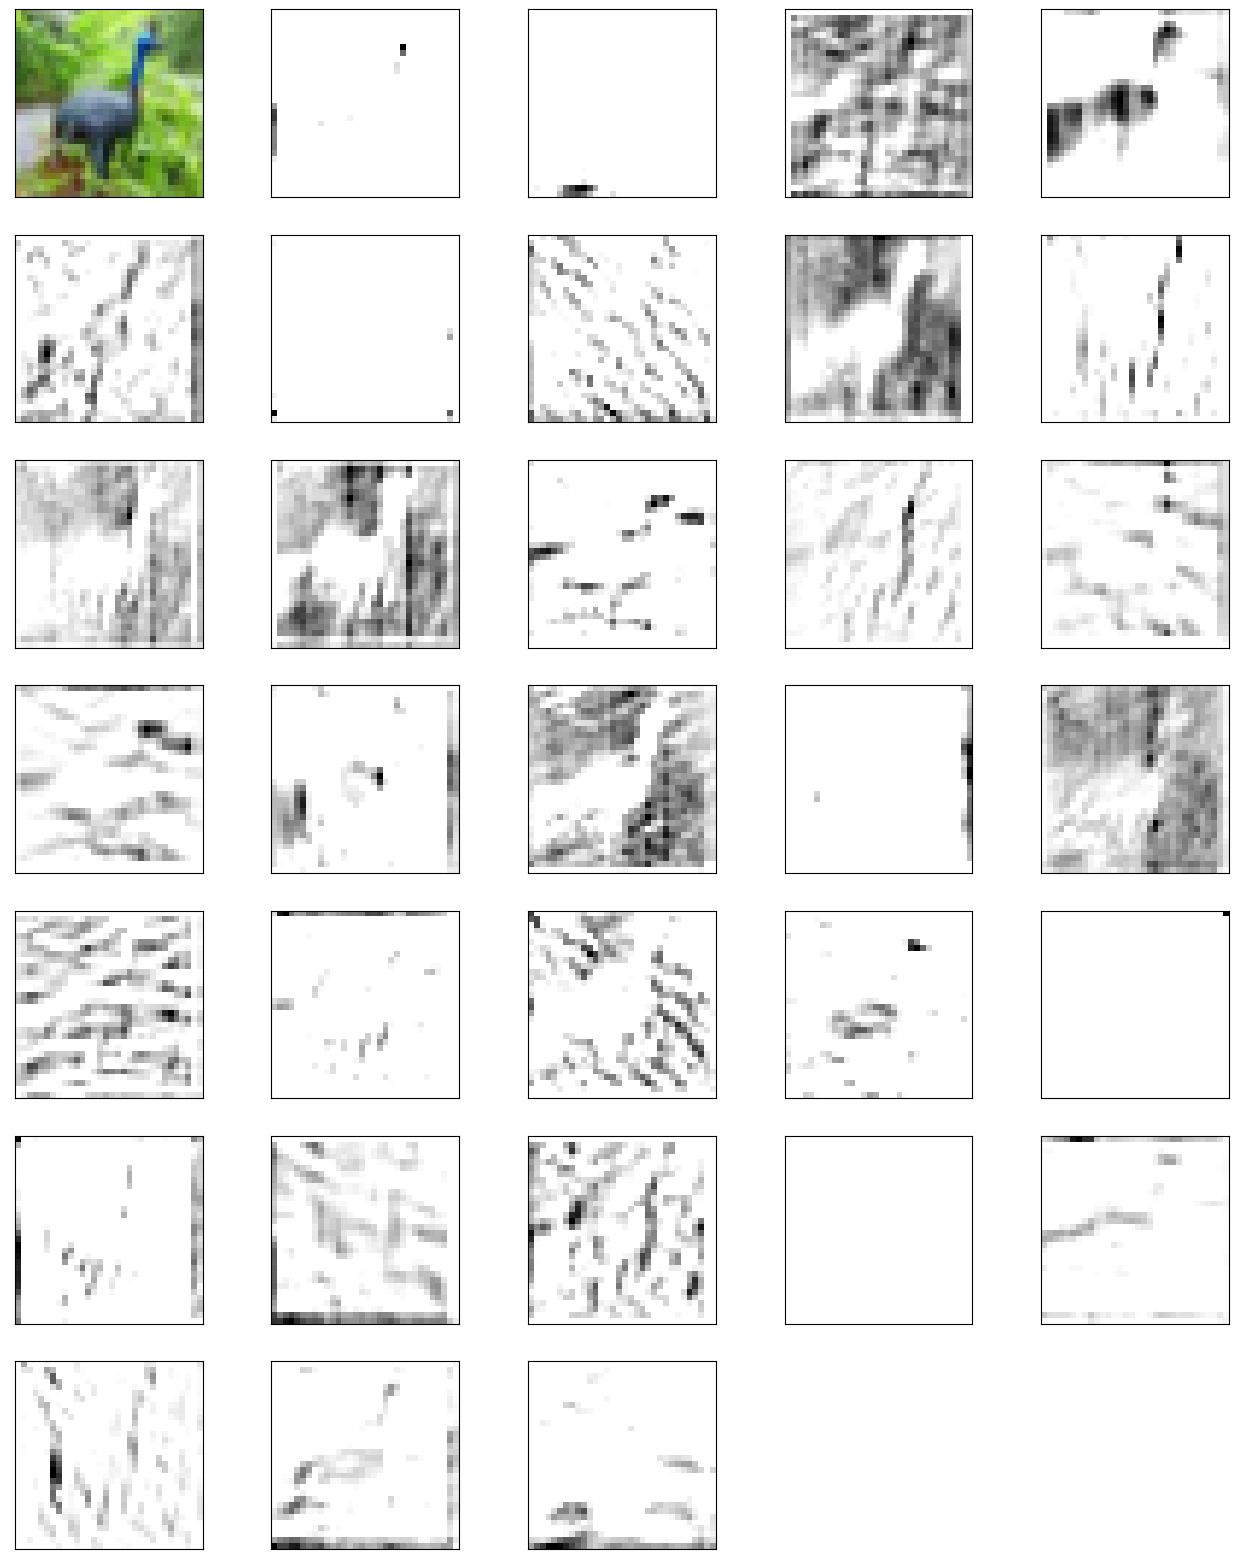

In [46]:
val = 2
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary')
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

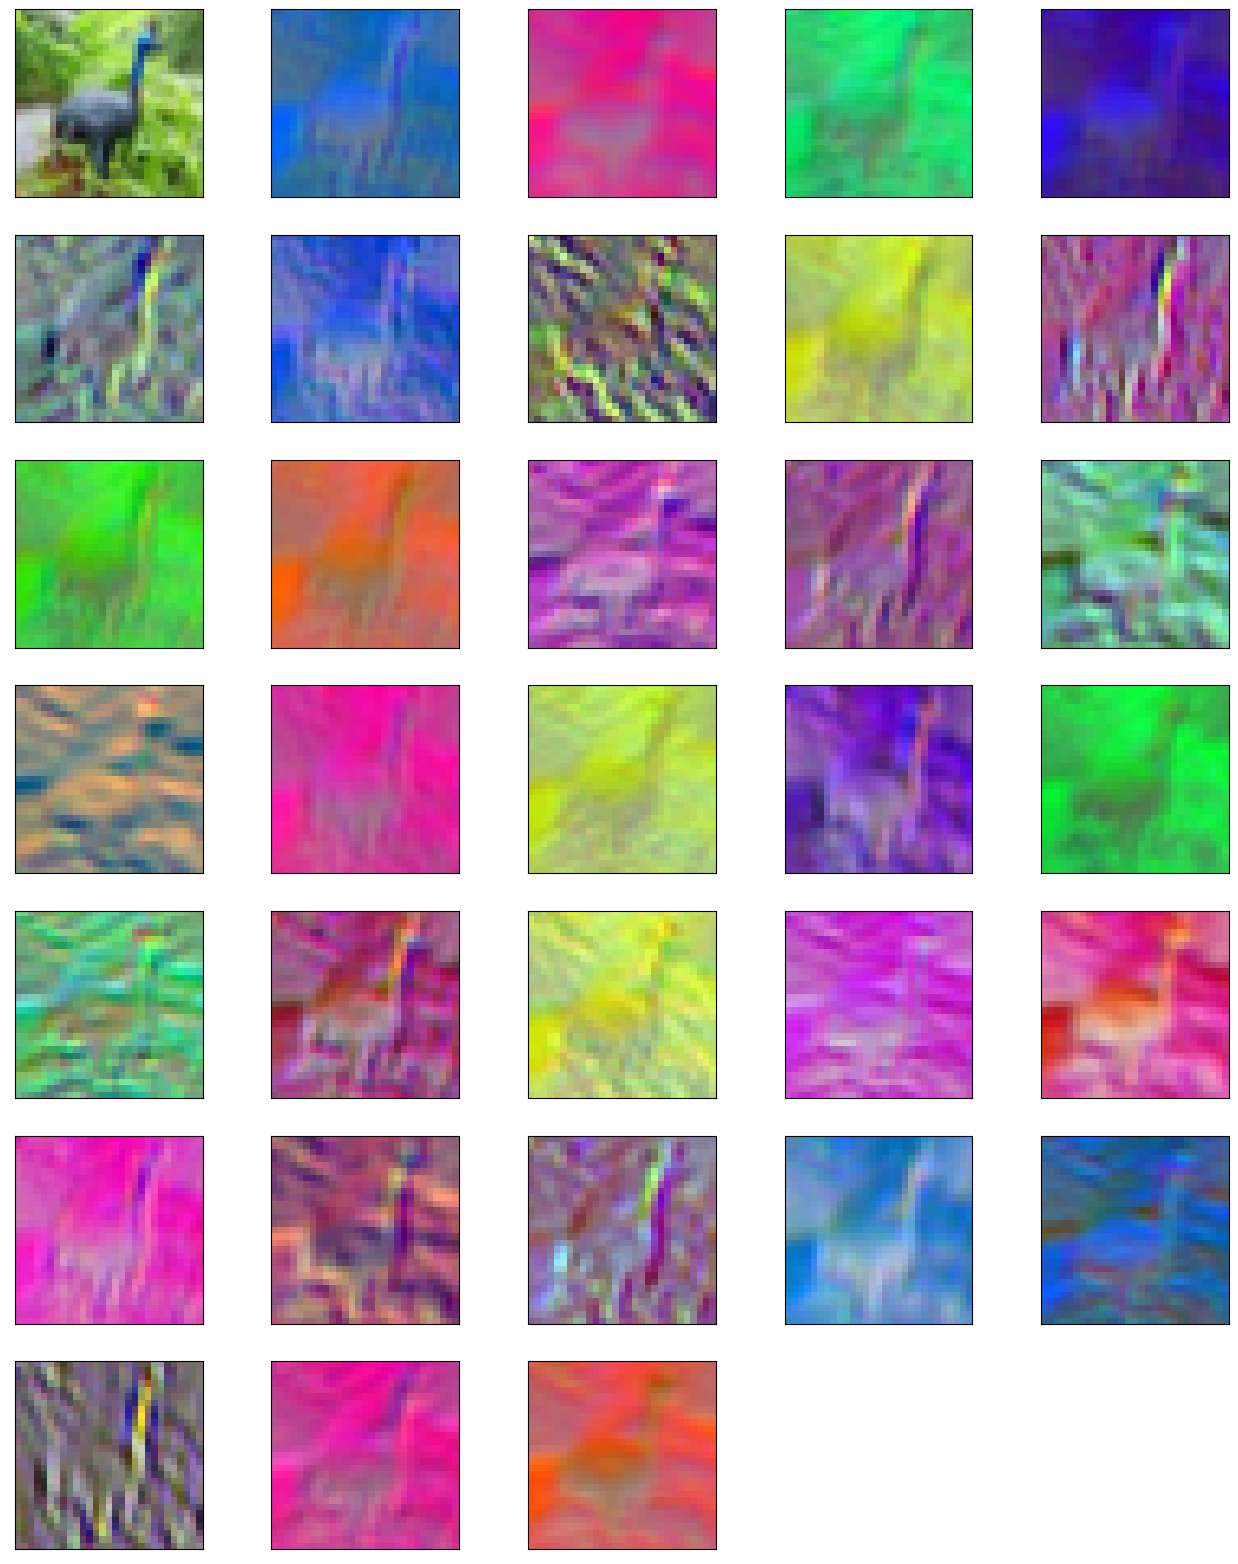

In [47]:
val = 2
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 19ms/step
(1, 32, 32)


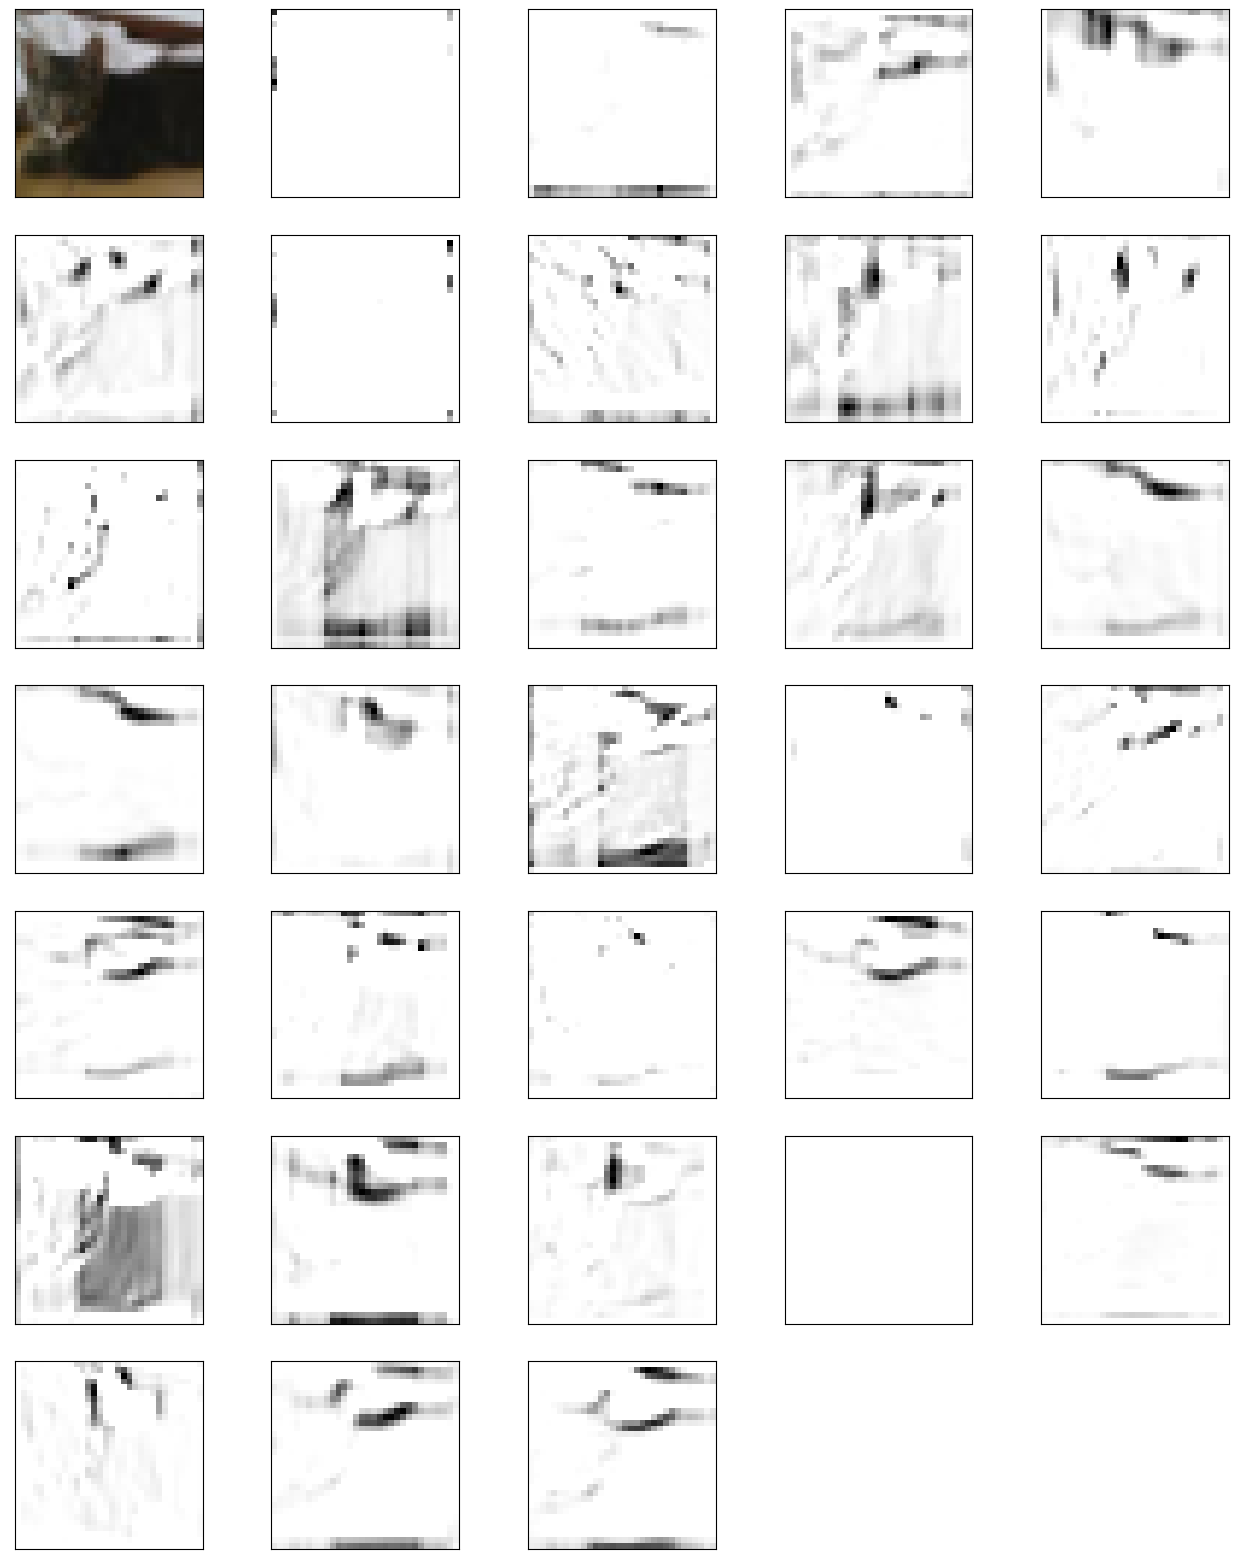

In [48]:
val = 3
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary')
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

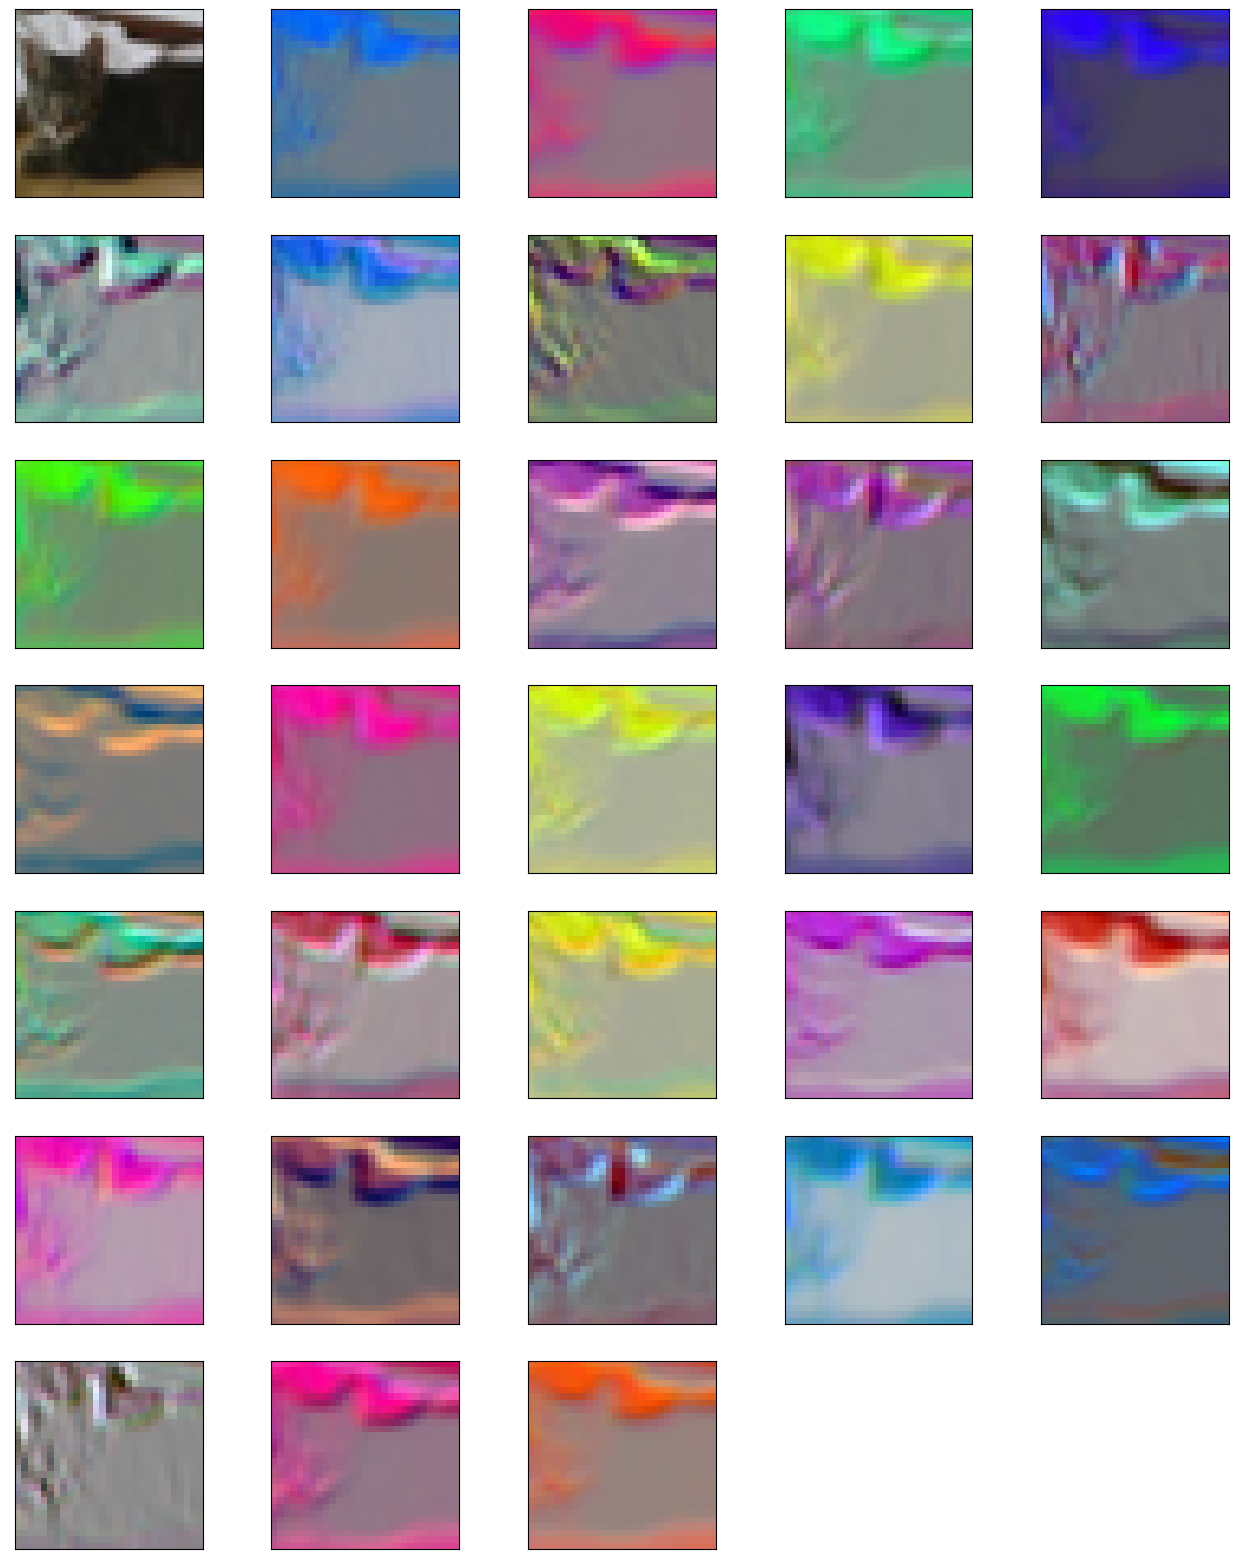

In [49]:
val = 3
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 18ms/step
(1, 32, 32)


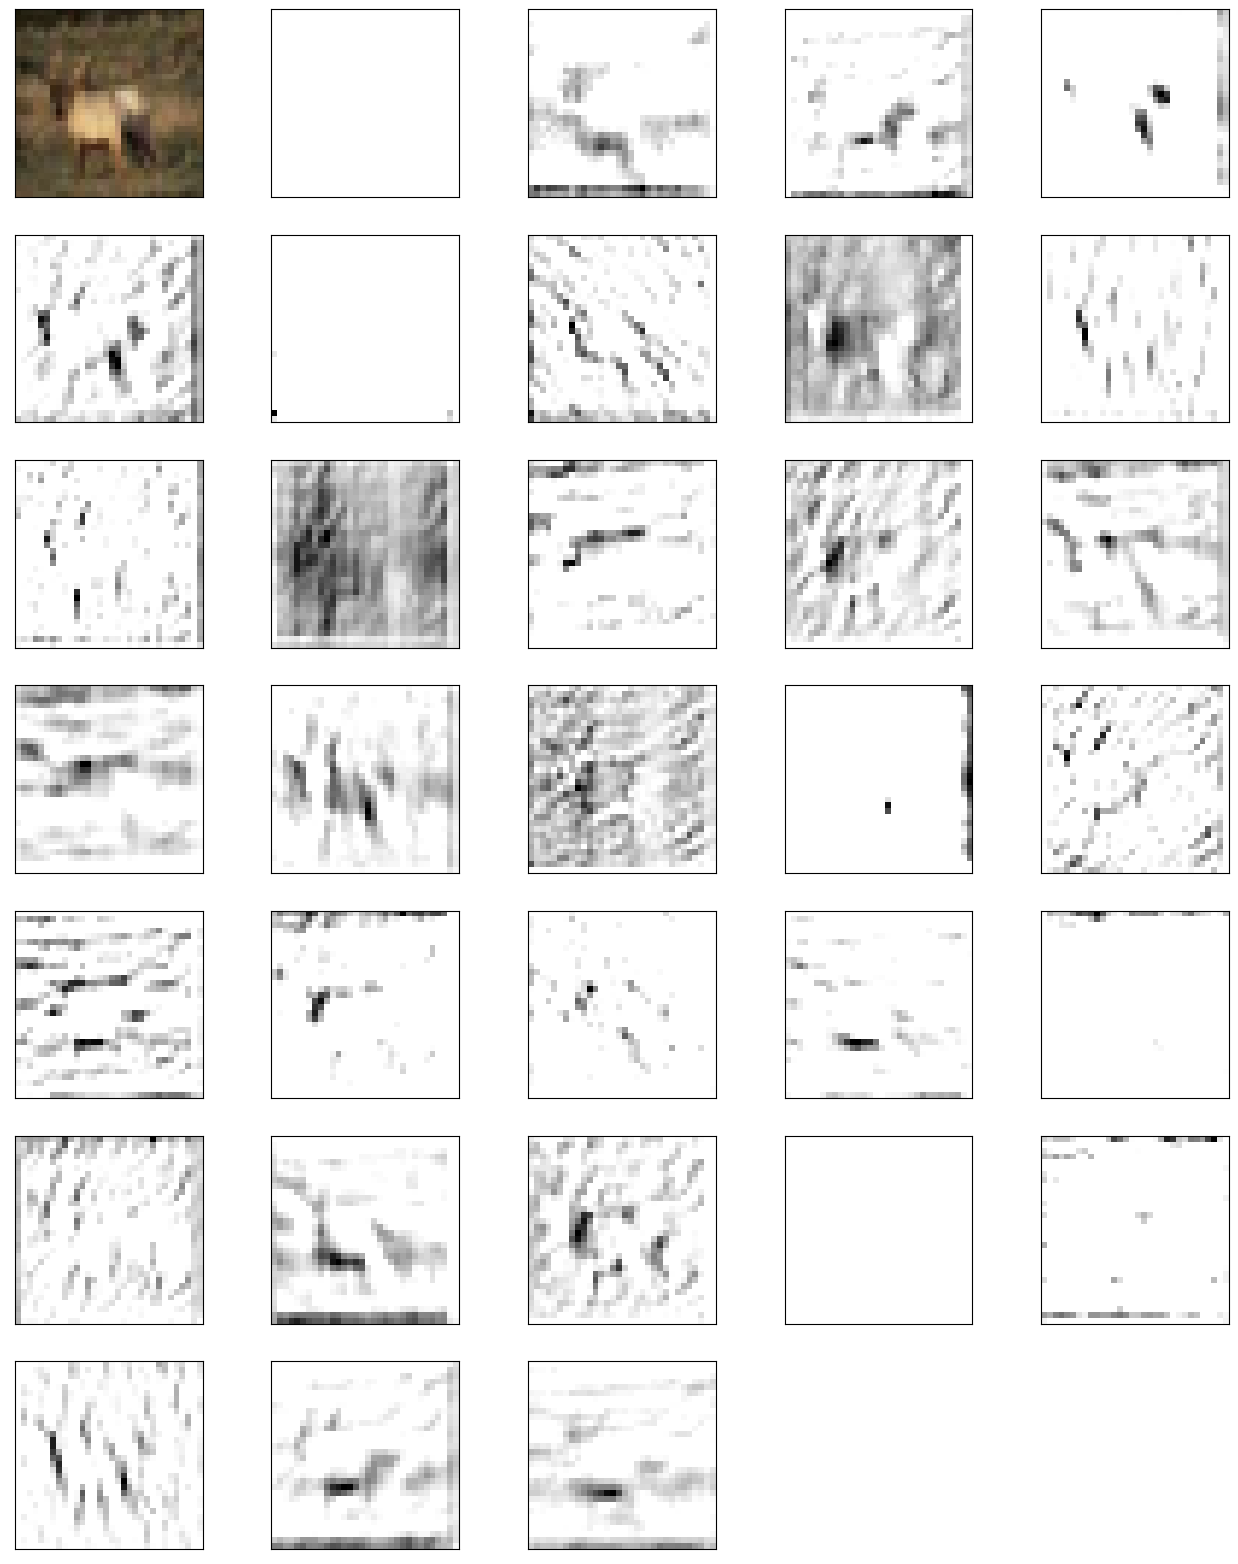

In [50]:
val = 4
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary')
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

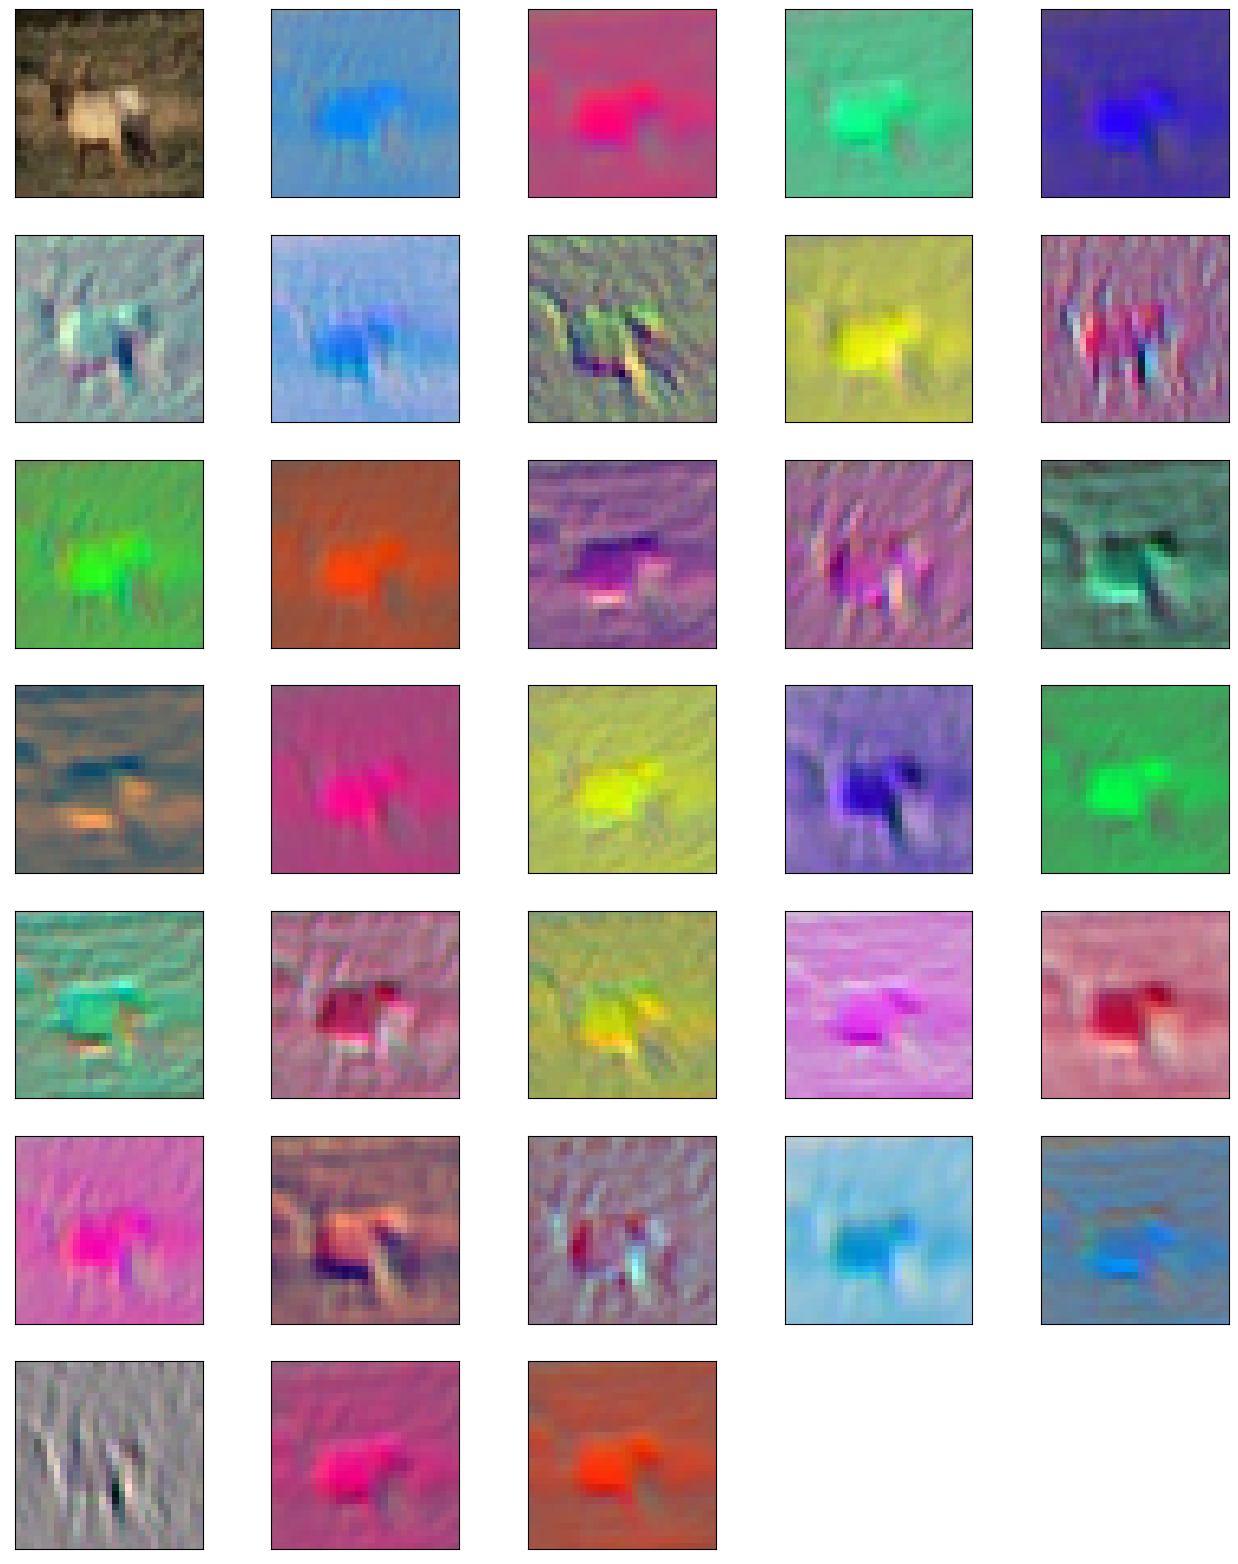

In [51]:
val = 4
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 18ms/step
(1, 32, 32)


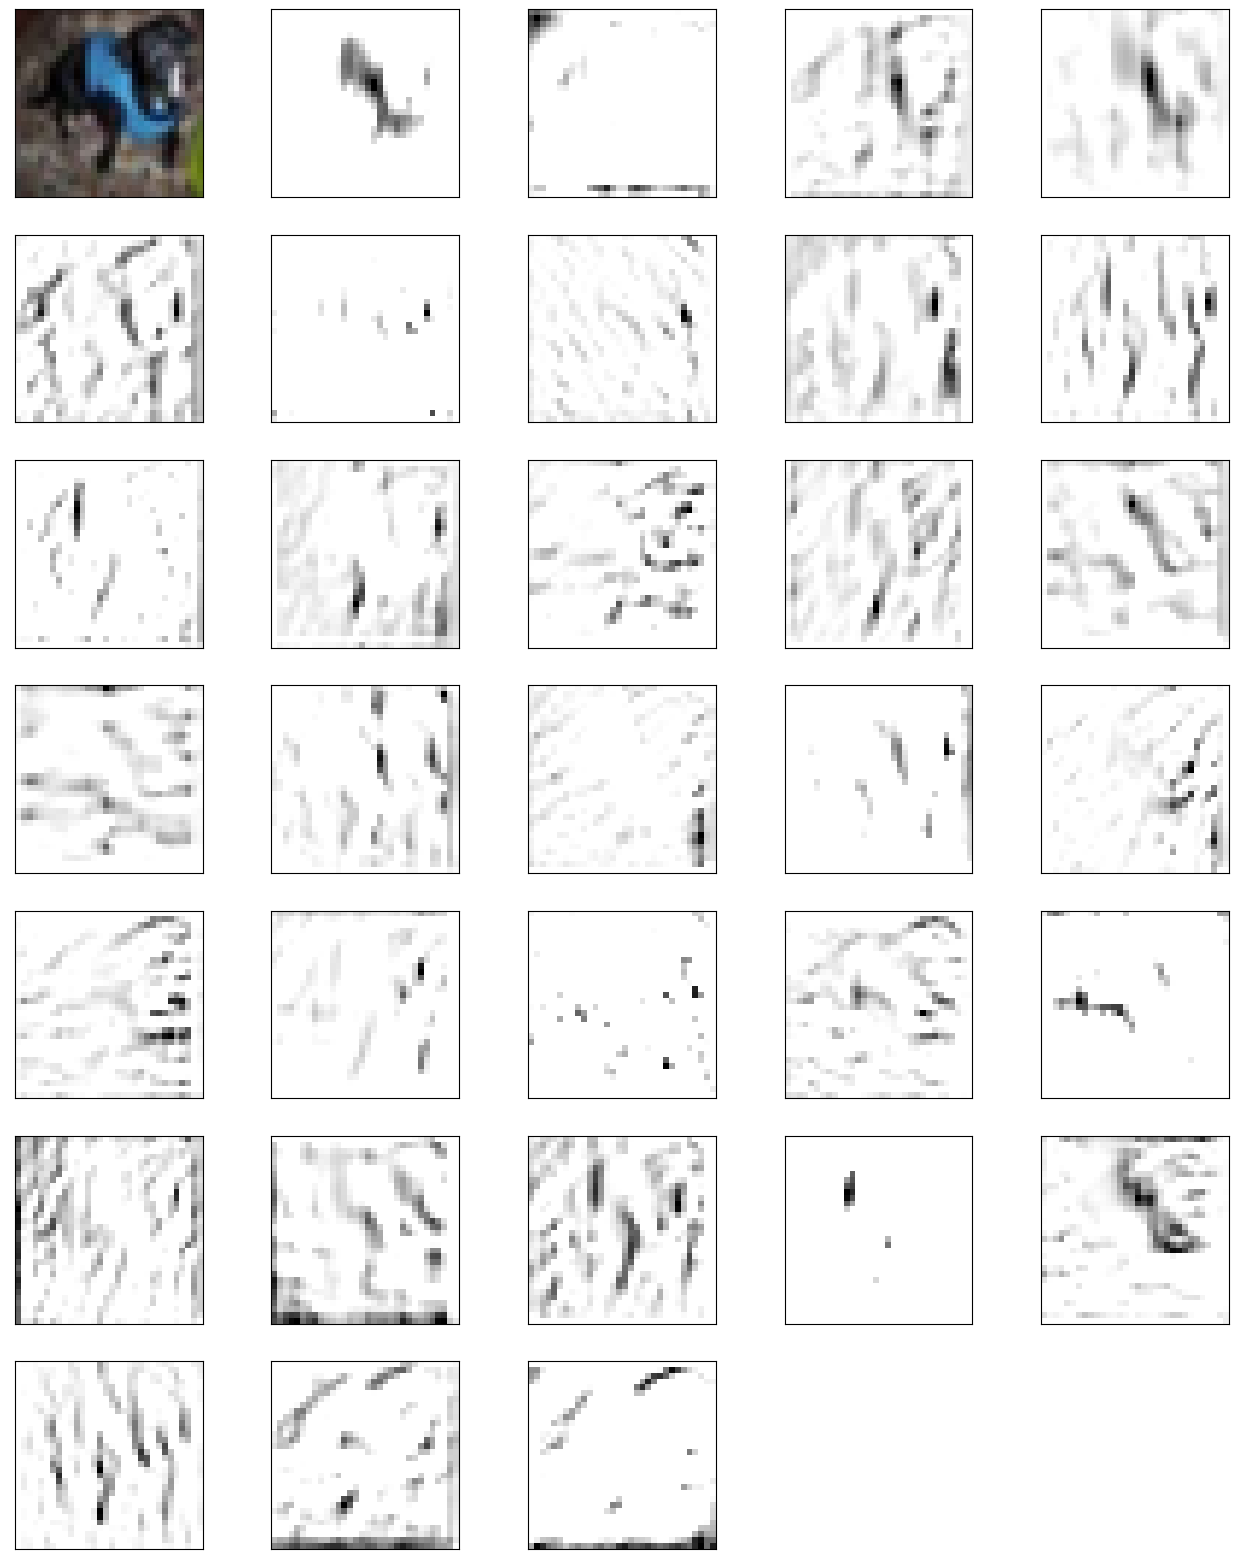

In [52]:
val = 5
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary')
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

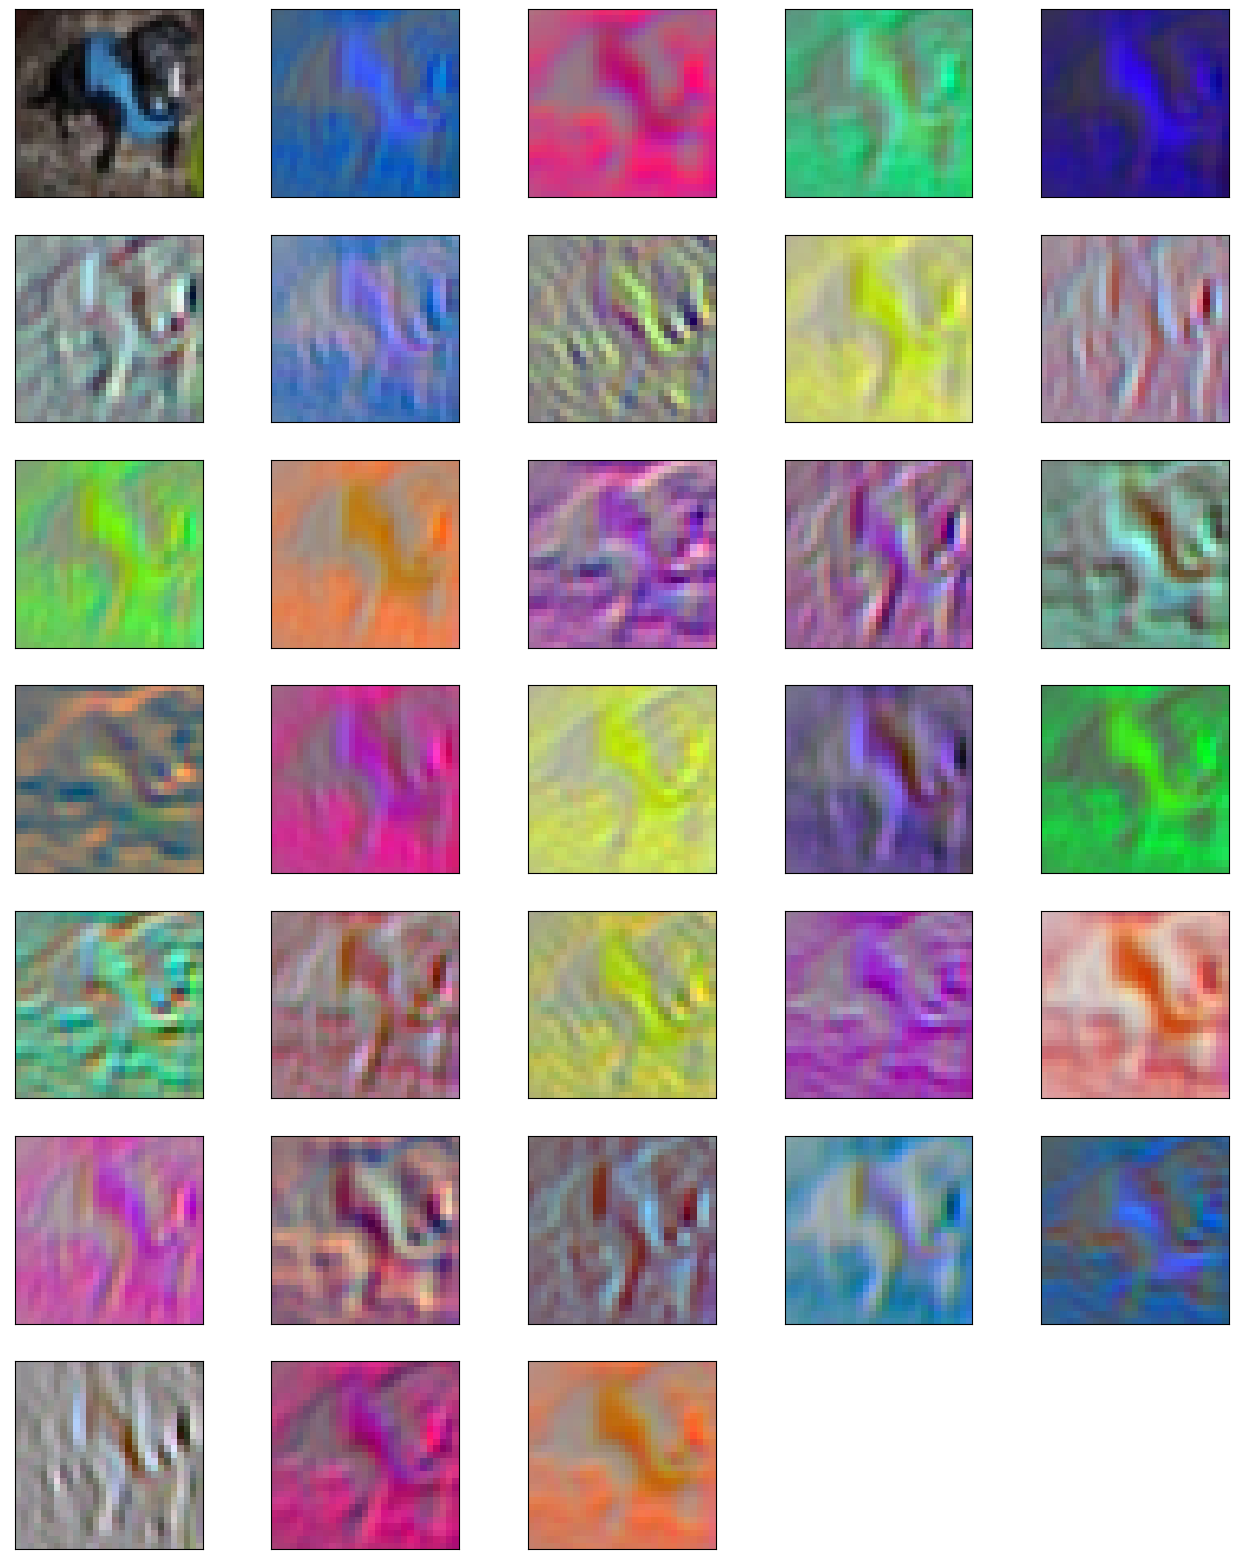

In [53]:
val = 5
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 18ms/step
(1, 32, 32)


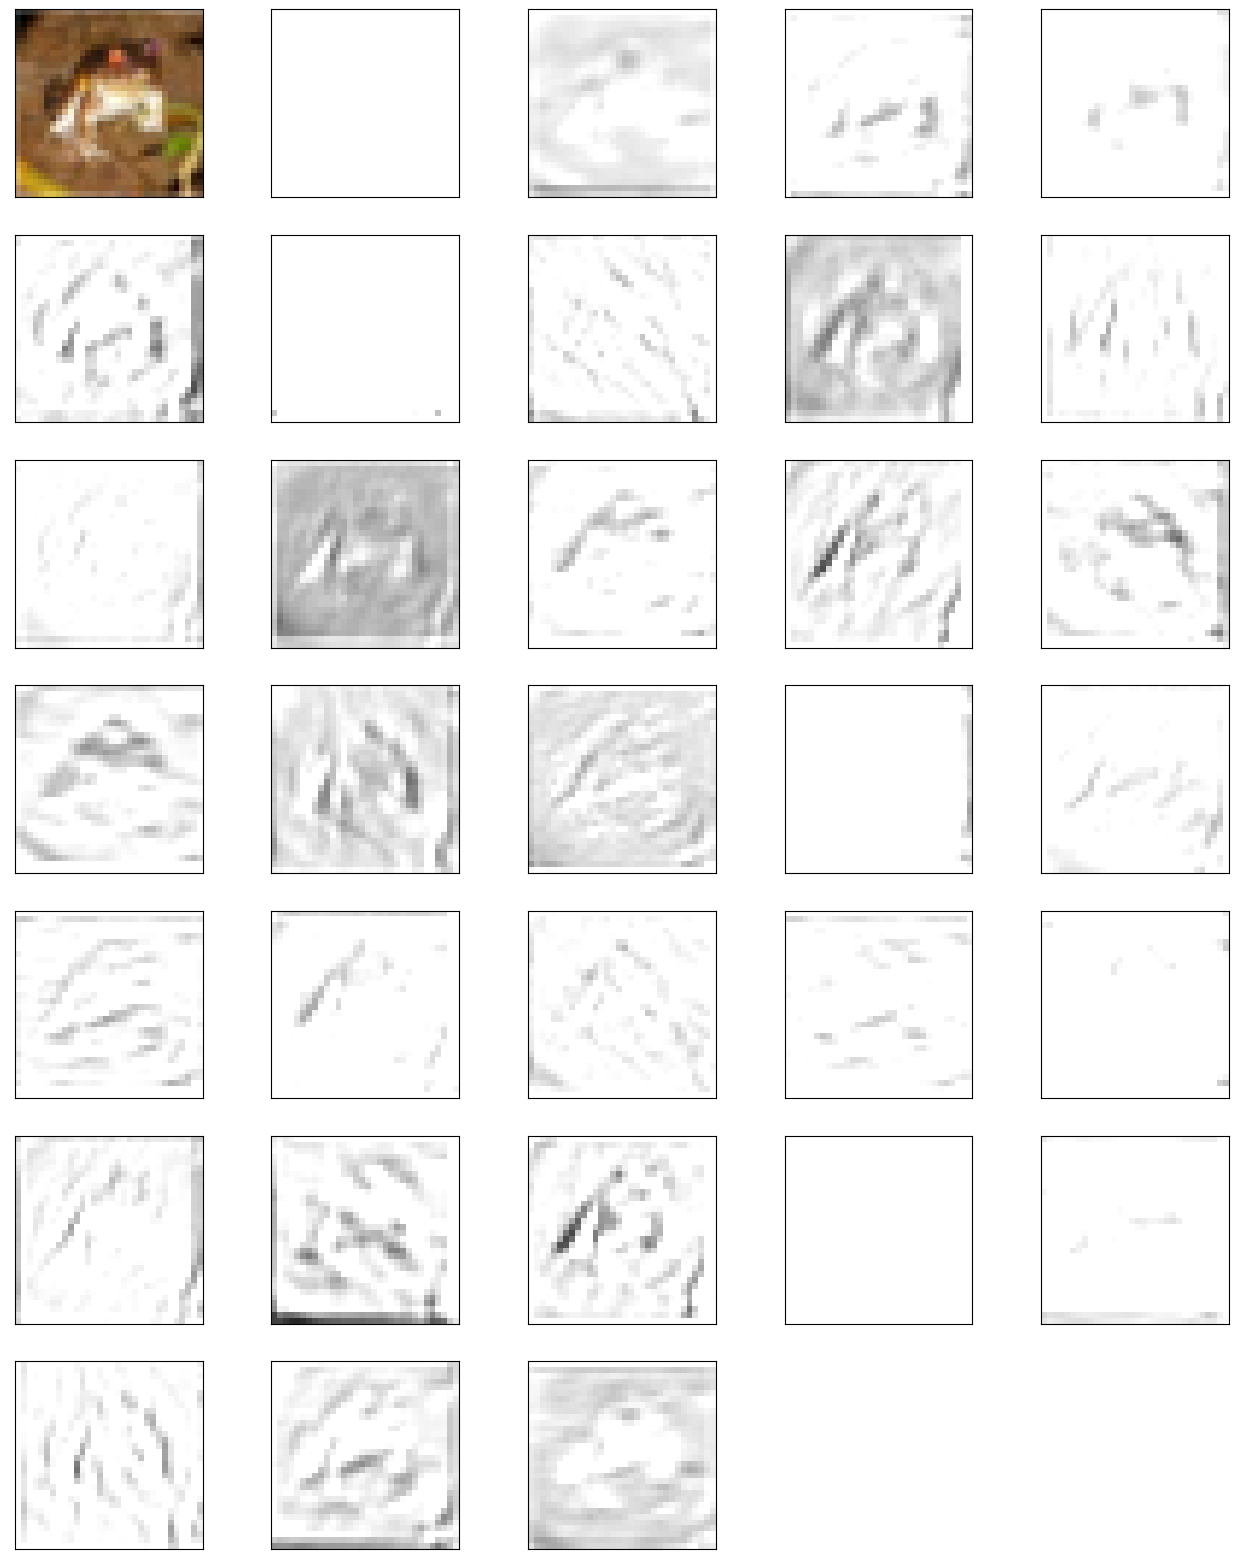

In [54]:
val = 6
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

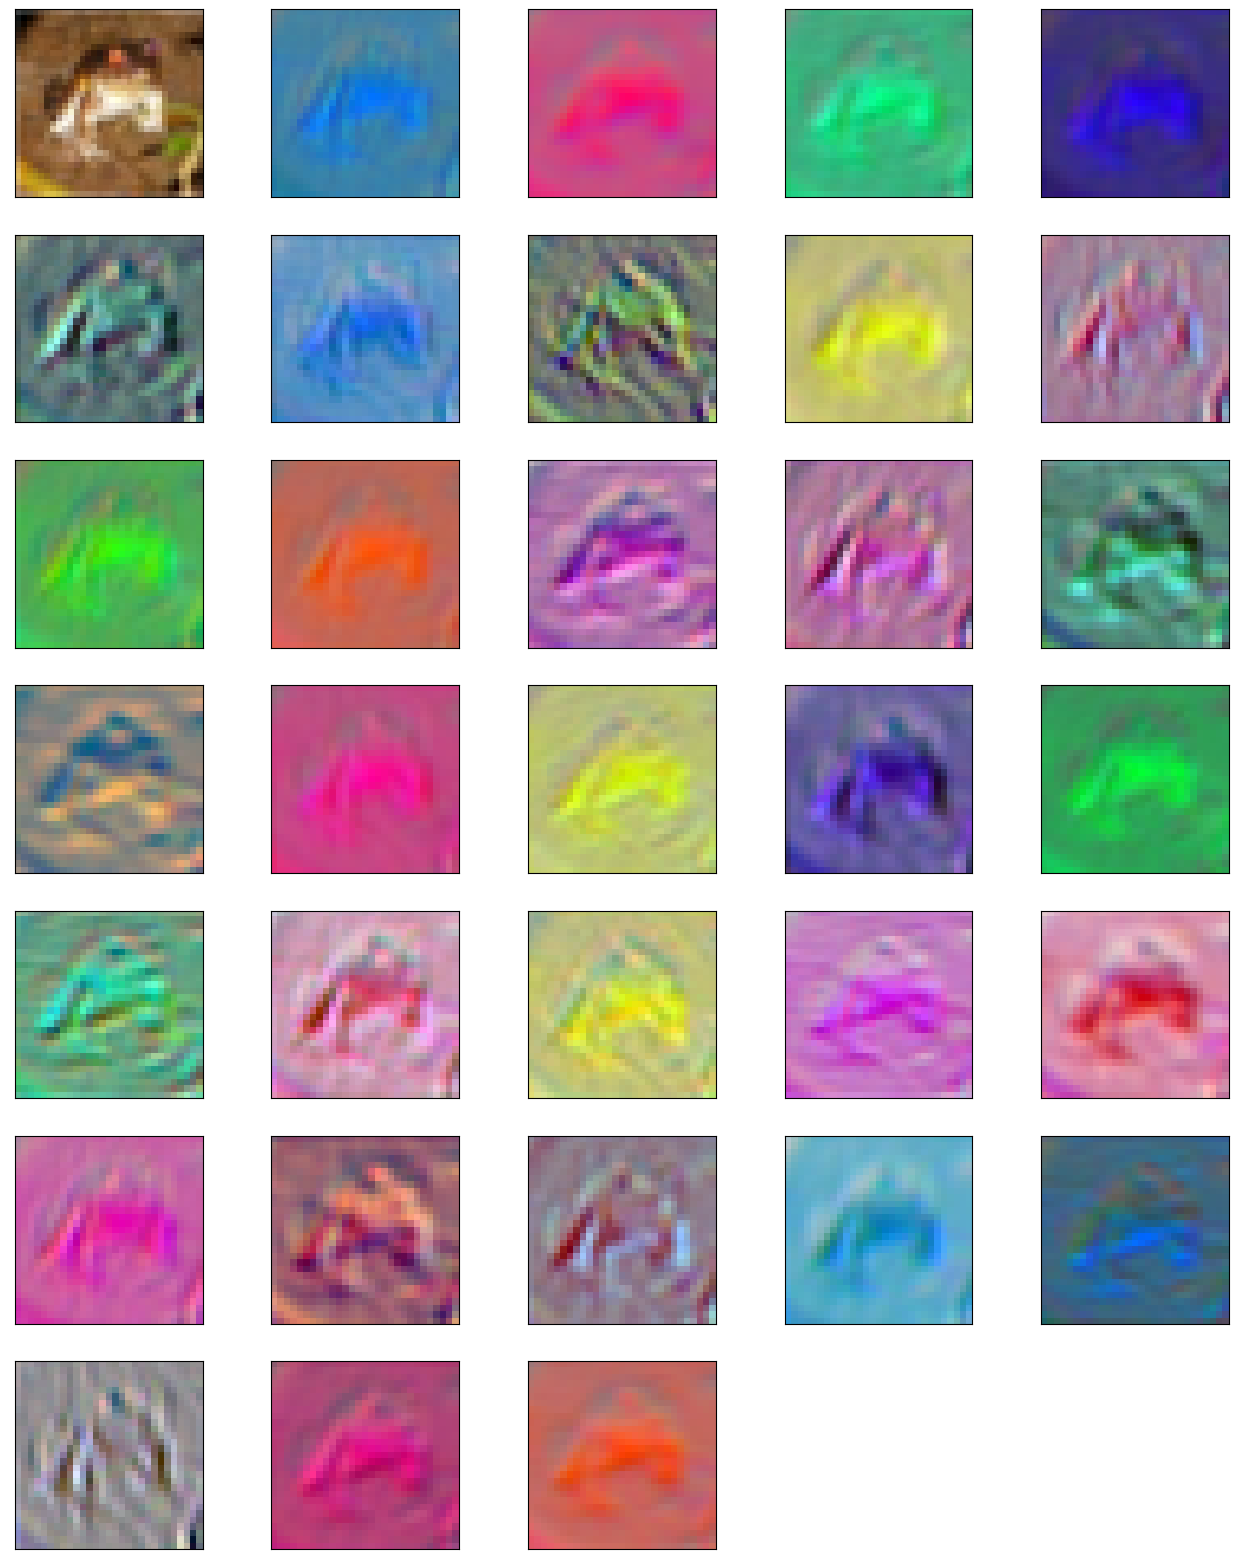

In [55]:
val = 6
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 16ms/step
(1, 32, 32)


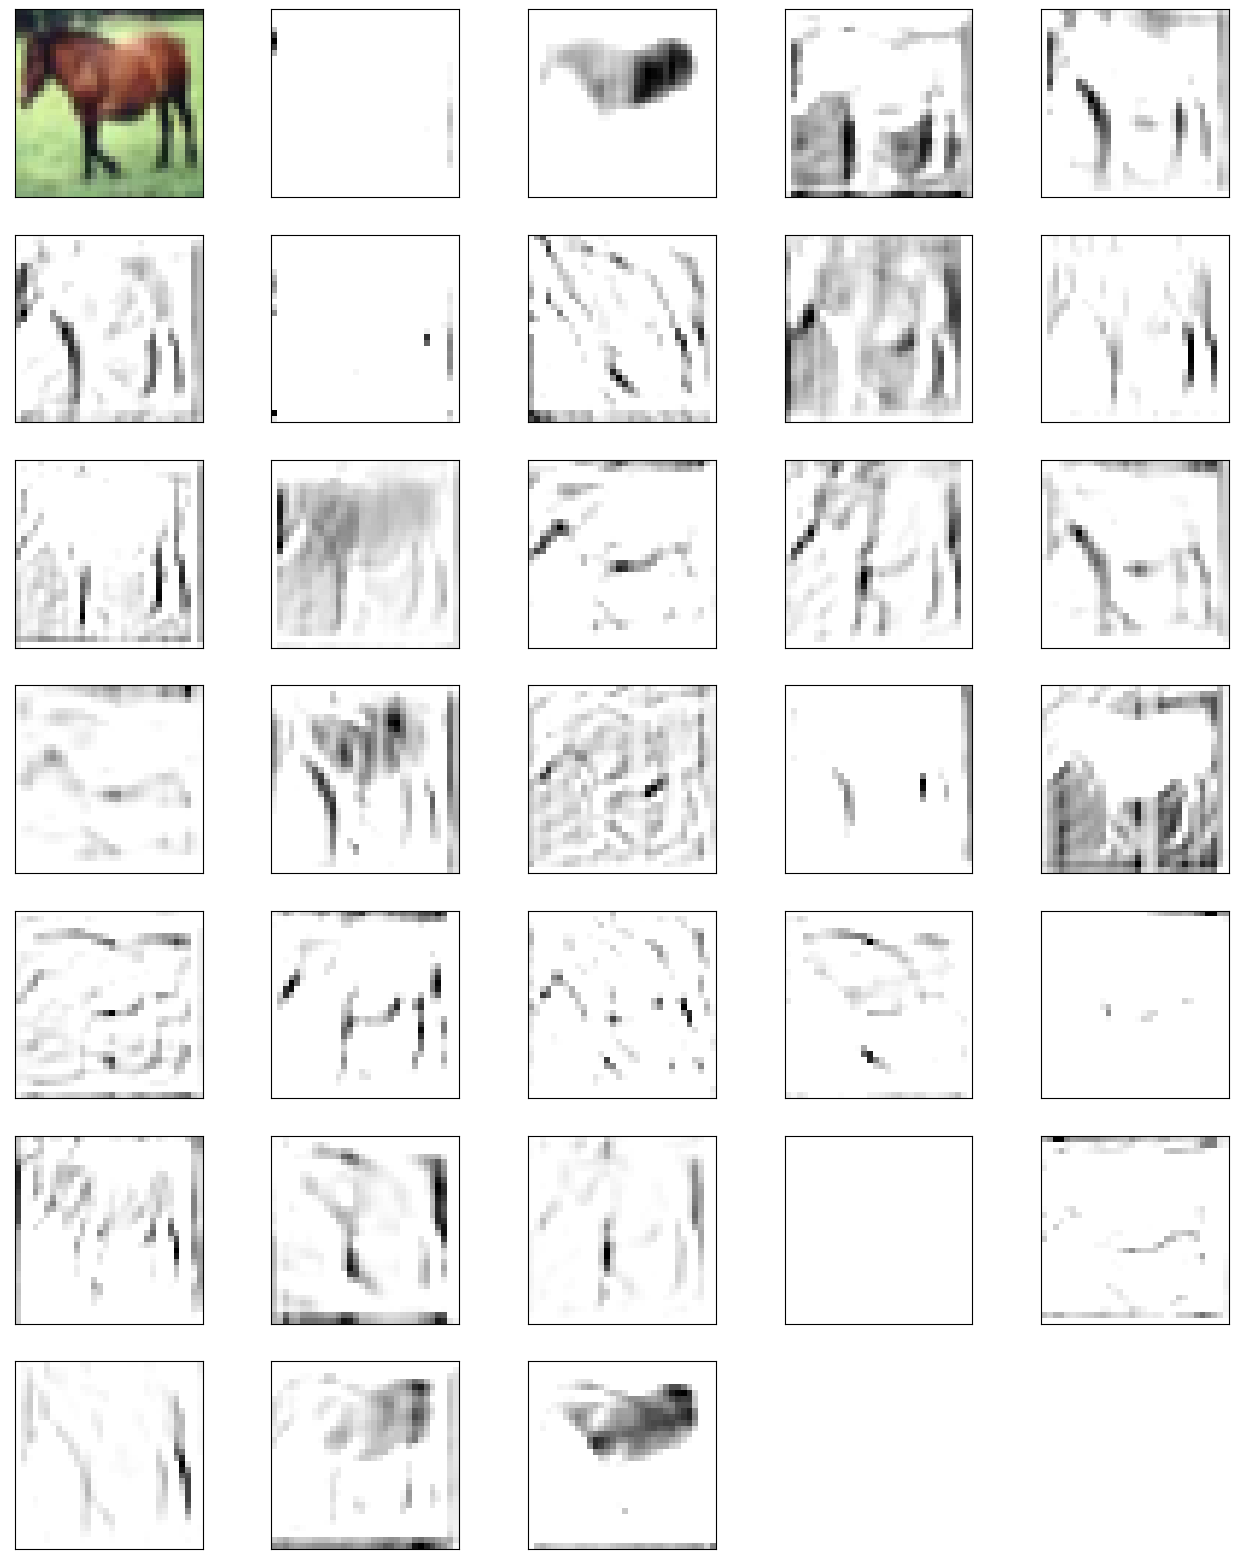

In [56]:
val = 7
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary')
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

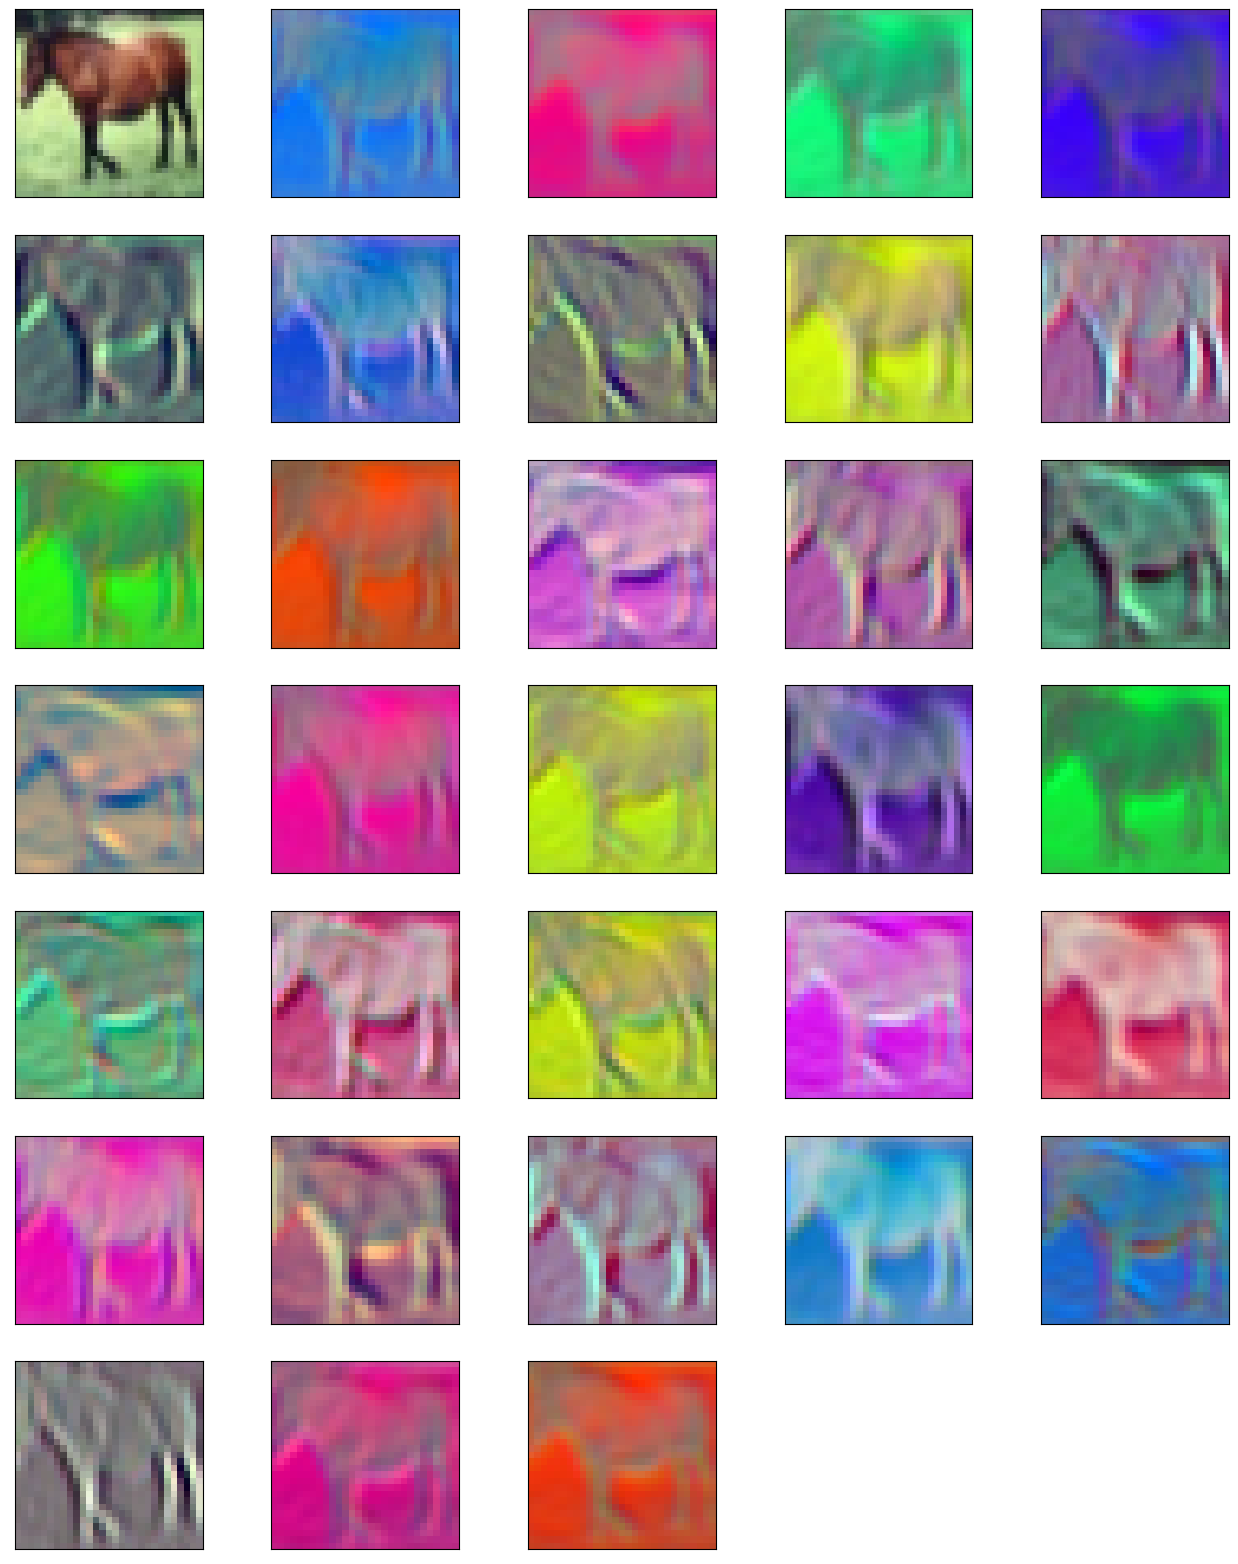

In [57]:
val = 7
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 18ms/step
(1, 32, 32)


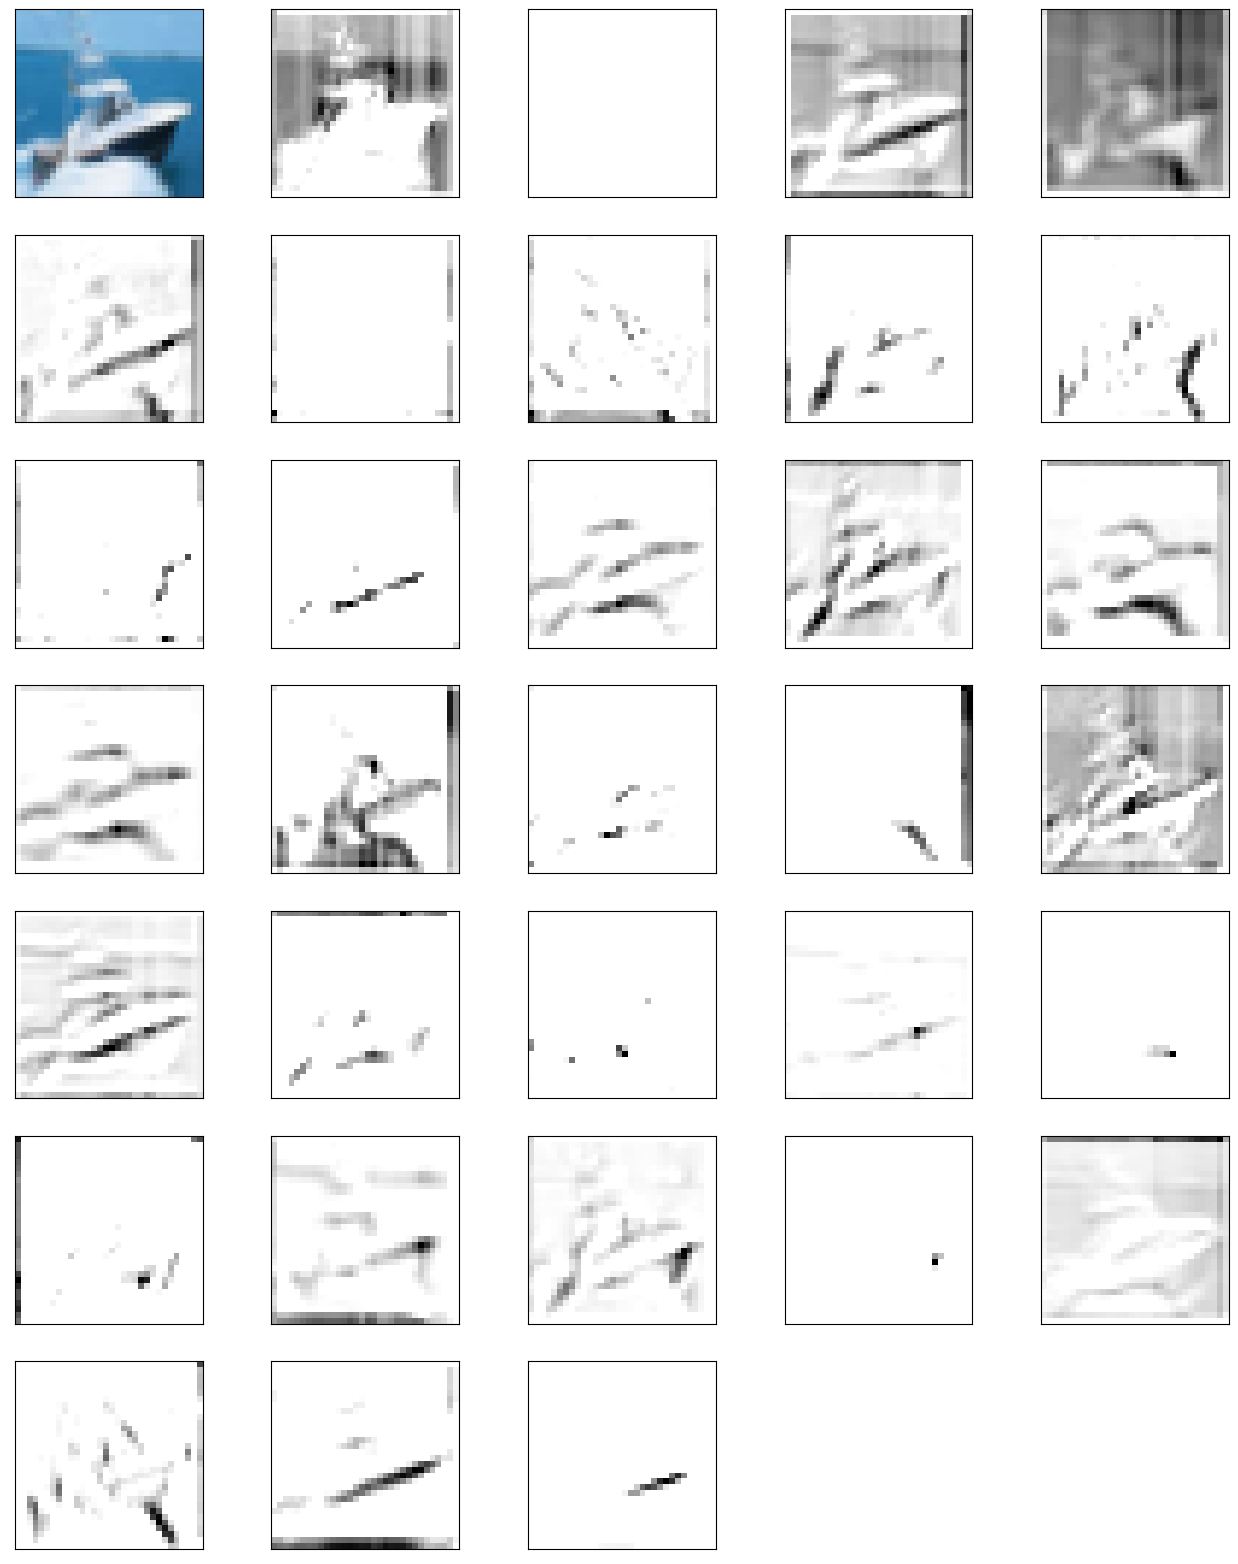

In [58]:
val = 8
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary')
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

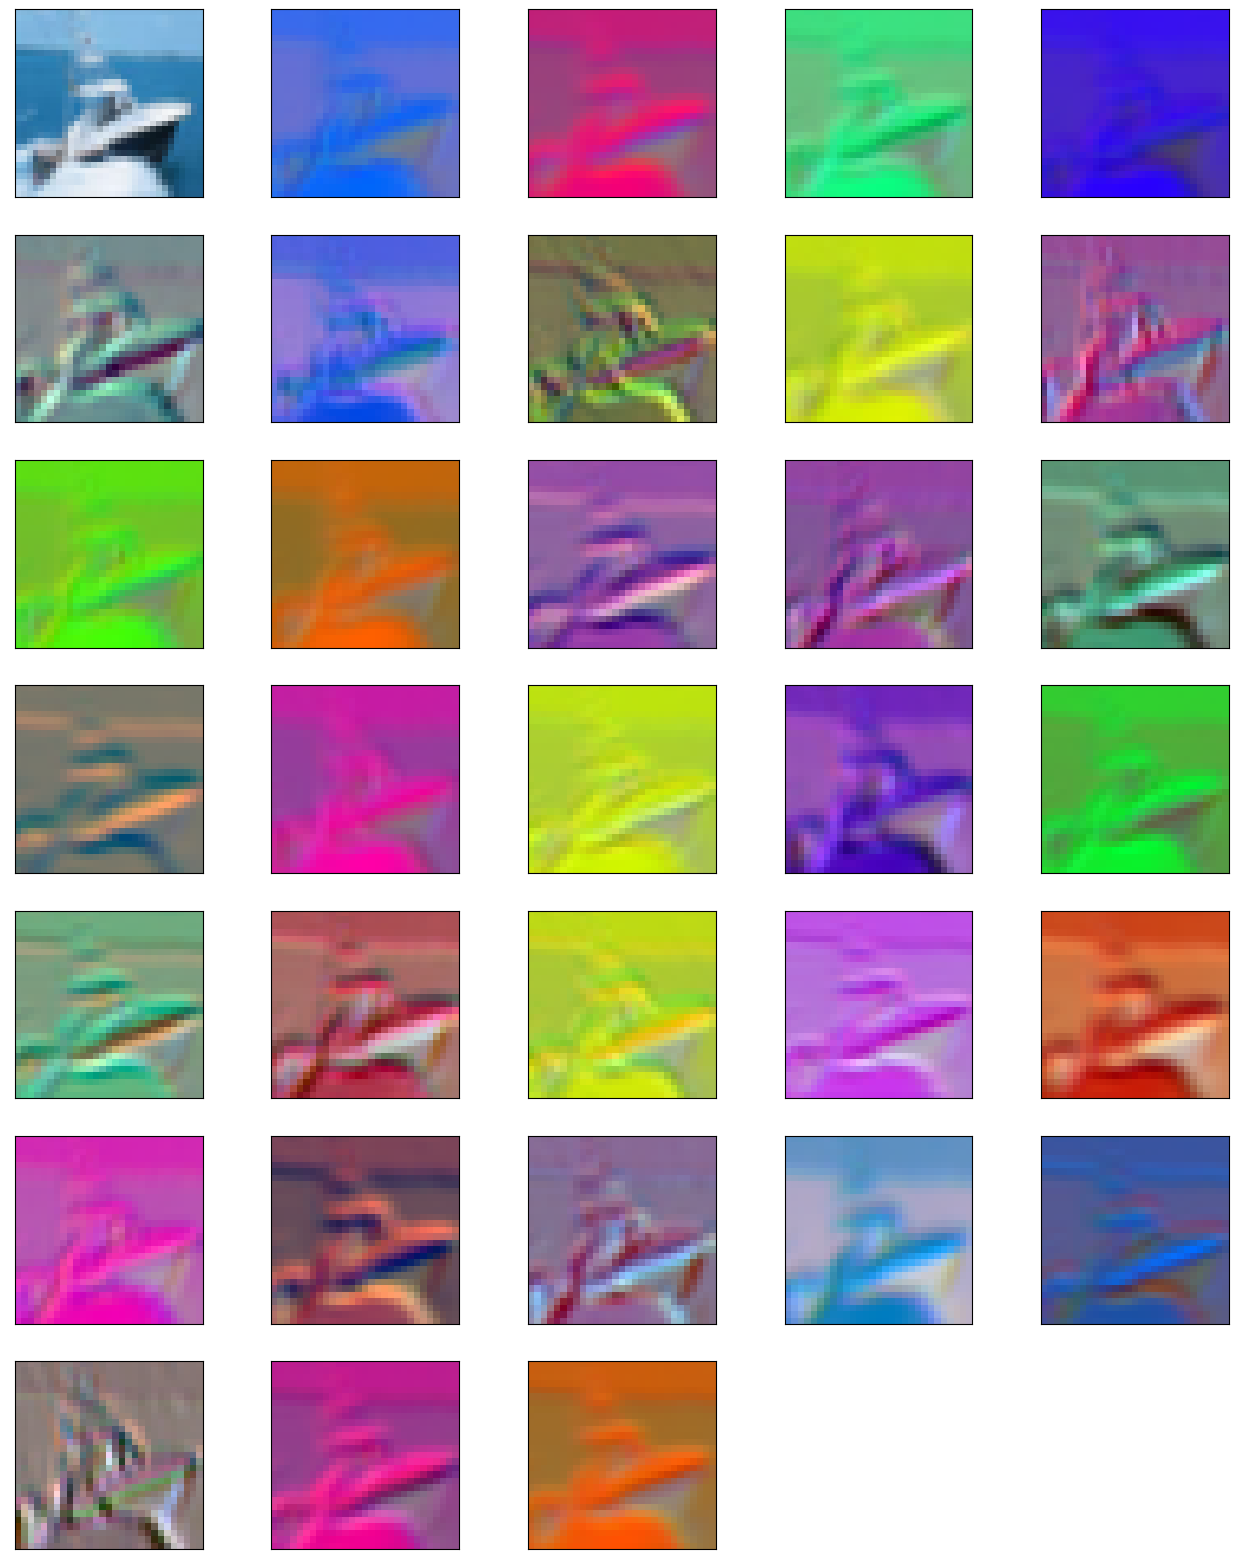

In [59]:
val = 8
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 17ms/step
(1, 32, 32)


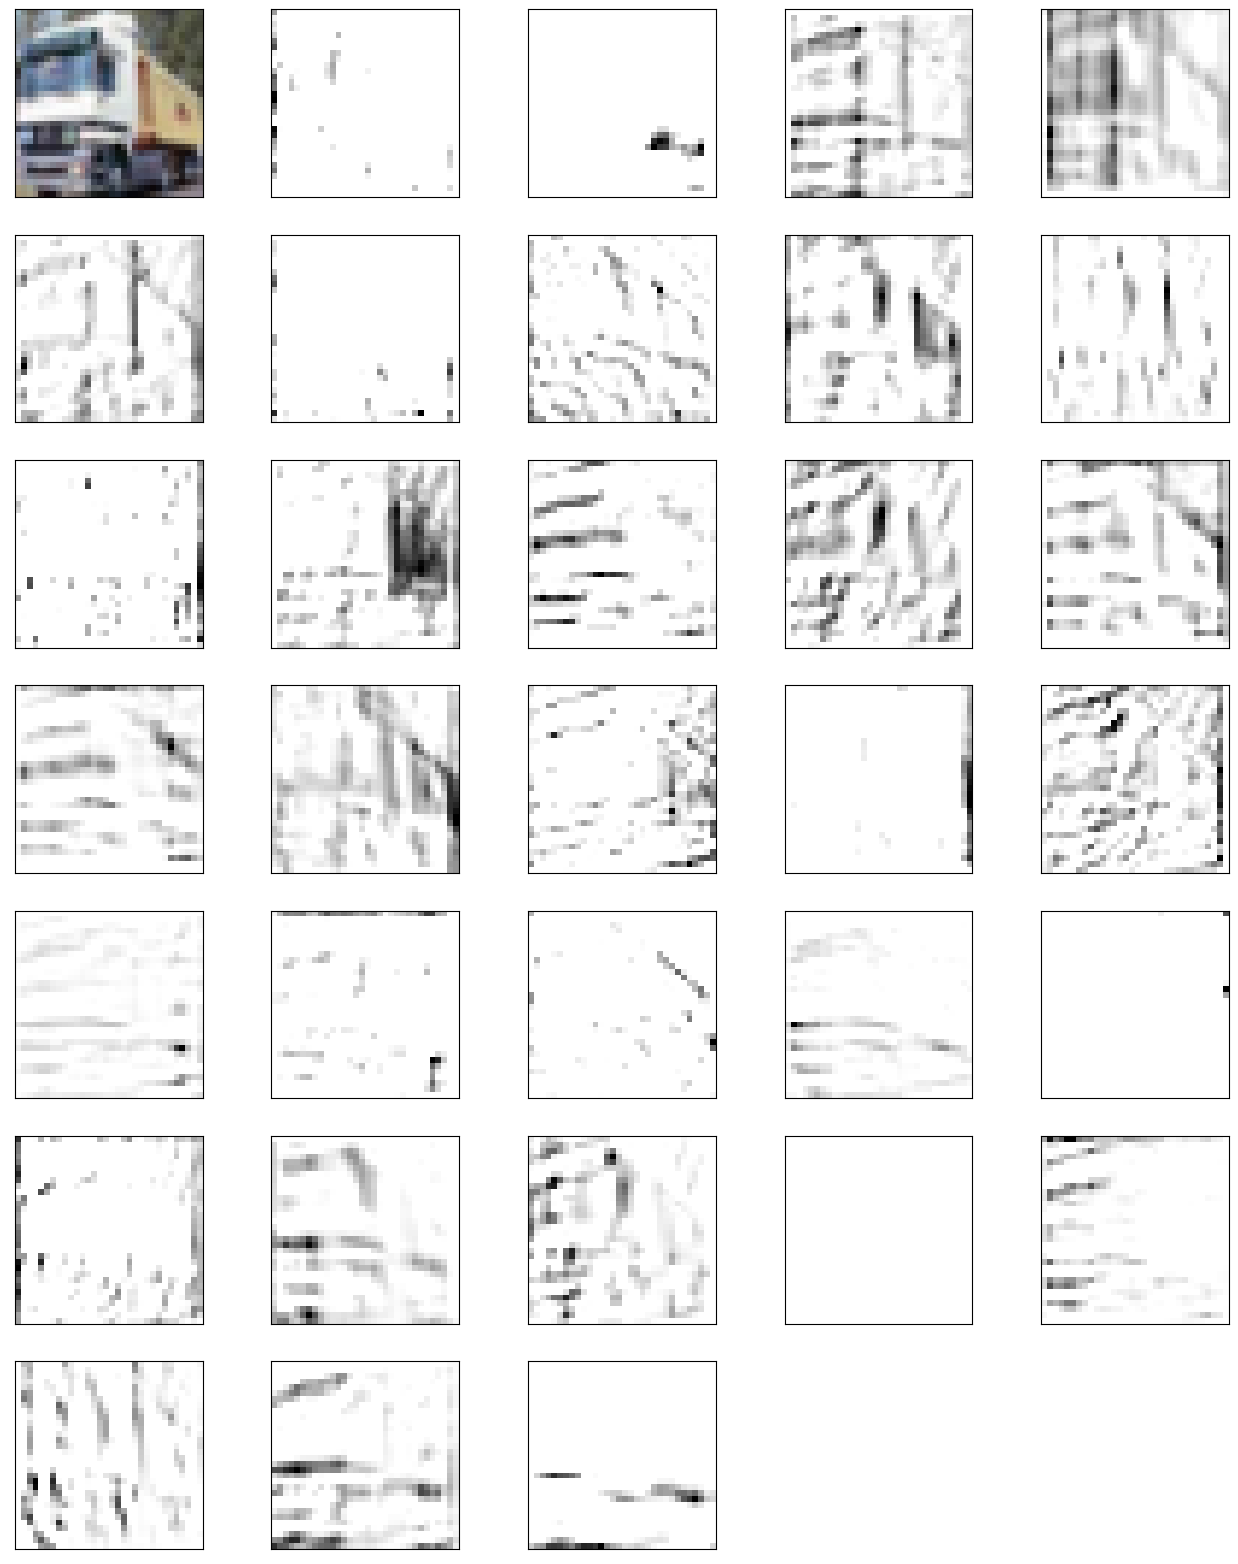

In [60]:
val = 9
img = x_train[samples[val]].reshape(1,32,32,3)

feature_maps = fmap_model.predict(img)
feature_maps = (feature_maps - np.min(feature_maps, axis=3)) / (np.max(feature_maps, axis=3) - np.min(feature_maps, axis=3))
print(feature_maps[:,:,:,0].shape)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary')
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

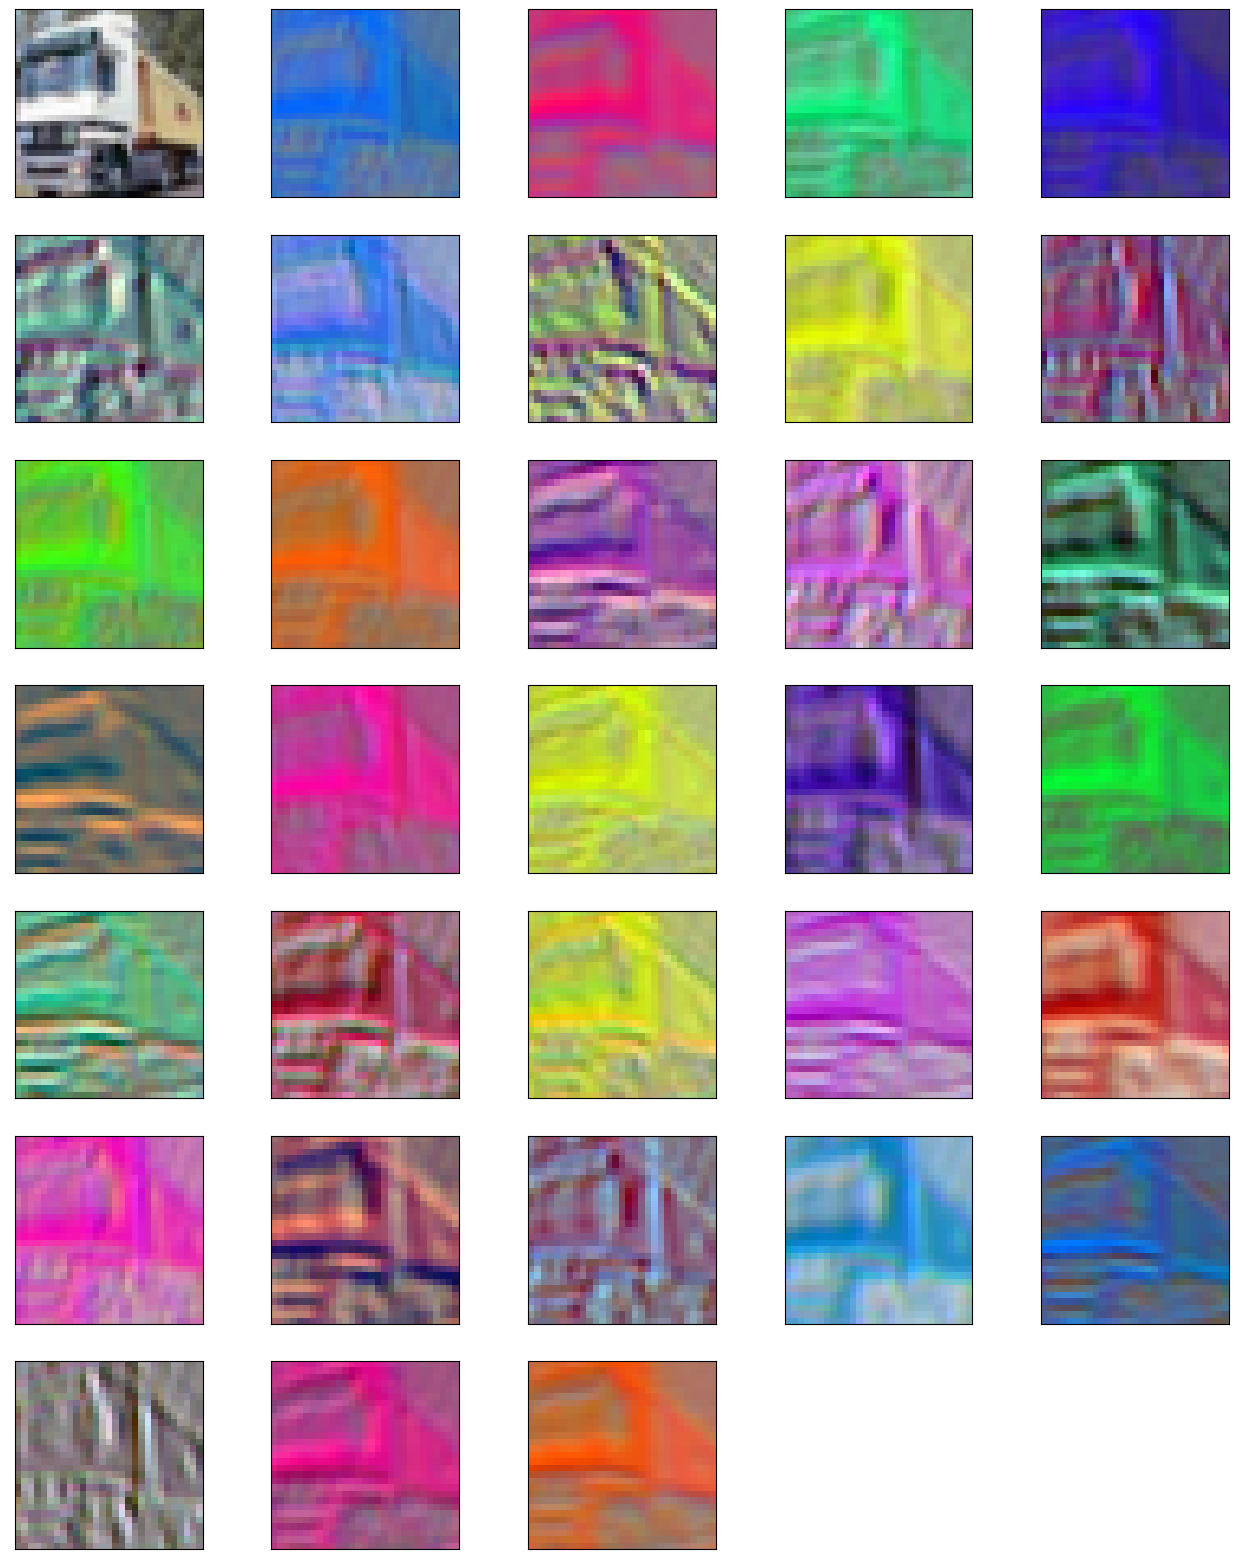

In [61]:
val = 9
img = x_train[samples[val]].reshape(1,32,32,3)

# plot original imapge and all 32 maps in a 3x11 square
nrows = 7
ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(32,32, 3))

ix = 1
for _ in range(len(kernels[0,0,0,:])):
    conv_img = np.dstack([convolve2D(img[0,:,:,i], kernels[:,:,i, ix-1], padding=0, strides=1) for i in range(3)])
    conv_img = (conv_img-np.min(conv_img))/(np.max(conv_img)-np.min(conv_img))
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filtered image
    axs[ix//ncols, ix%ncols].imshow(conv_img)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

In [83]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 167.4 kB/s eta 0:00:0000:0100:01


ImportError: cannot import name '_Conv' from 'tensorflow.python.keras.layers.convolutional' (/opt/anaconda3/envs/RLDS/lib/python3.10/site-packages/tensorflow/python/keras/layers/convolutional.py)